In [ ]:
import kinase_library as kl
testsequence='PSVEPPLsQETFSDL'

# Create a Substrate object with a target sequence (example: p53 S33)
s = kl.Substrate(testsequence)  # Lowercase 's' indicates a phosphoserine

# Predict potential kinase interactions for the substrate
s.predict()

In [ ]:
"""Task 1 - to write code mutating first amino acid to every other possible amino acid"""
#how to replace one letter for another in test sequence.

#how to replace one letter for each amino acid



In [ ]:
mutated_sequences = [] #creates a list to store the mutated amino acids
amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # defines the standard 20 amino acids
for i, original_aa in enumerate(testsequence): #indexes the original amino acids 
    for new_aa in amino_acids: #creates a loop of all amino acids
        if new_aa != original_aa:  # Avoid replacing with itself
                mutated_seq = testsequence[:i] + new_aa + testsequence[i+1:] #creates a new sequence (mutated seq)
                mutated_sequences.append(mutated_seq) #stores mutated sequence

print(f'Mutated sequences (# sequences = {len(mutated_sequences)})')
print(mutated_sequences)
 #shows mutations at each position


        

In [ ]:
'''
Task2 - Run these sequences through the predict function and store the output as a csv file. Look at pandas.to_csv() for this.
Output should be 280 separate csv files. Don't worry about a naming convention yet. 
'''



In [ ]:
import os
os.makedirs("mutations", exist_ok=True)
#creates a new folder called mutations to put the sequence predictions into

In [ ]:
import kinase_library as kl
import pandas as pd

testsequence = 'PSVEPPLsQETFSDL'  
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
mutated_sequences = []  
wild_type_filename = f"mutations/wildtype.csv"


# Predict kinase data for the wild-type sequence
try:
    wild_type_substrate = kl.Substrate(testsequence)
    wild_type_predictions = wild_type_substrate.predict()

    # Save wild-type predictions to CSV
    df_wild_type = pd.DataFrame(wild_type_predictions)
    df_wild_type.to_csv(wild_type_filename, index=False)

    print(f"Wild-type sequence predictions saved to {wild_type_filename}")

except Exception as e:
    print(f"Error processing wild-type sequence: {e}")

for i, original_aa in enumerate(testsequence):  
    for new_aa in amino_acids:
        if new_aa != original_aa:  
                mutated_seq = testsequence[:i] + new_aa + testsequence[i+1:] 
                mutated_sequences.append((i, original_aa, new_aa, mutated_seq))  


print(f"Total mutations generated: {len(mutated_sequences)}") 

for i, original_aa, new_aa, mutated_seq in mutated_sequences: 
    try:
        s = kl.Substrate(mutated_seq)
        predictions = s.predict()


        df = pd.DataFrame(predictions)

        # Save to CSV file with a structured name
        filename = f"mutations/mutation_Pos{i}_{original_aa}_to_{new_aa}.csv"
        df.to_csv(filename, index=False)

    except Exception as e:
        print(f"Skipping mutation at position {i} ({original_aa} → {new_aa}): {e}")





In [ ]:
'''
Task3 - Run through the 286 csv files and extract the order of the kinases. Then using the test sequence as the reference.
Compute a metric for each pair using something similar to LCS (link for inspo attached - https://chatgpt.com/share/67c705a9-9c74-8001-a8da-eac57f06384f)  
'''

In [ ]:
import os
import pandas as pd
from difflib import SequenceMatcher

#This extracts the kinase orders from 269 files - one being the reference sequence.
#I assume some mutations at position 7 are skipped due to the lack of phosphoacceptor.
#So giving 18 fewer LCS scores compared to the number of CSV files generated earlier.
#This is consistent with the data shown on the heatmap in the next cell.

mut_predictions = "mutations/"

wildtype_path = os.path.join(mut_predictions, "wildtype.csv")

df_wildtype = pd.read_csv(wildtype_path)

wildtype_kinase_order = df_wildtype["Score Rank"].tolist()  #extracts kinase orders from the reference sequence

kinase_orders = {}

#reads all files to extract the kinase orders (except wildtype as that's already been done)
for file in os.listdir(mut_predictions):
    if file.endswith(".csv") and file != "wildtype.csv":
        file_path = os.path.join(mut_predictions, file)
        try:
            df = pd.read_csv(file_path)
            
            if "Score Rank" in df.columns:
                kinase_orders[file] = df["Score Rank"].tolist()  # Store kinase order
            else:
                print(f"Skipping {file}: No 'Score Rank' column found.") 
        
        except Exception as e:
            print(f"Error reading {file}: {e}")   #debugging steps

print(f"Extracted kinase orders from {len(kinase_orders)} mutation CSVs.") 

# Function to compute Longest Common Subsequence (LCS)
def longest_common_subsequence(seq1, seq2):
    matcher = SequenceMatcher(None, seq1, seq2)
    return sum(block.size for block in matcher.get_matching_blocks())

#finds the LCS between wildtype and mut seqs
lcs_scores = {}
for file, order in kinase_orders.items():
    lcs_length = longest_common_subsequence(order, wildtype_kinase_order)
    lcs_scores[file] = lcs_length

#normalizes LCS scores between 0 and 1
if lcs_scores:
    lcs_min = min(lcs_scores.values())
    lcs_max = max(lcs_scores.values())

    normalized_lcs = {file: (score - lcs_min) / (lcs_max - lcs_min) for file, score in lcs_scores.items()}

   
    df_lcs = pd.DataFrame(list(normalized_lcs.items()), columns=['Mutation_File', 'Normalized_LCS'])
    
    print("\nNormalized LCS Scores:")
    print(df_lcs.sort_values(by="Normalized_LCS", ascending=True))  # Sort by lowest LCS

else:
    print("No LCS scores calculated. Ensure kinase_orders contains data.")


In [ ]:
'''
Task 4: generate heatmaps of LCS ratio for each mutation on the y axis and position on the x axis. I like plotly heatmaps for this
https://plotly.com/python/heatmaps/. So output will be a heat map showing hotspots for the mutations that disrup the phosphorylation motif the most
'''

In [ ]:
import os
import pandas as pd
import re
import plotly.express as px
import numpy as np

lcs_data = []

for file, normalized_score in normalized_lcs.items():
    
    match = re.match(r"mutation_Pos(\d+)_\w+_to_(\w+)\.csv", file)

    if match:
        position = int(match.group(1)) 
        mutated_aa = match.group(2)  

        lcs_data.append([position, mutated_aa, normalized_score])


df_lcs = pd.DataFrame(lcs_data, columns=['Position', 'Mutation', 'LCS_Ratio'])


heatmap_matrix = df_lcs.pivot_table(index='Mutation', columns='Position', values='LCS_Ratio')


fig = px.imshow(
    heatmap_matrix,
    labels={'x': 'Mutation Position', 'y': 'Mutated Amino Acid', 'color': 'LCS Ratio'},
    color_continuous_scale='Temps',
    title="Heatmap of LCS Ratios for Each Mutation",
)

# Format axes
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        dtick=1  # Show every position
    ),
    yaxis=dict(
        tickmode='linear',
        dtick=1  # Show every position
    ),
    coloraxis_colorbar=dict(
        tickvals=[0, 0.25, 0.5, 0.75, 1],  # Set scale from 0 to 1
        ticktext=["0.0", "0.25", "0.5", "0.75", "1.0"]
    ),
    plot_bgcolor='white'  
)
fig.show()






In [ ]:
"Generate tables and subplots showing cases for high and low LCS"

In [ ]:
import os
import pandas as pd
from difflib import SequenceMatcher
import matplotlib.pyplot as plt

# Define paths and variables
mut_predictions = "C:/Users/ricea/OneDrive/Documents/GitHub/Annabel-BSc-Project/mutations"
kinase_orders = {}
mutated_sequences = []

def extract_mutated_sequences():
    """Reads CSV files and extracts mutated sequences from the file names."""
    global mutated_sequences
    for file in os.listdir(mut_predictions):  # Finds the CSVs, reads the CSVs
        if file.endswith(".csv") and file != "wildtype.csv":  # Exclude wildtype.csv
            # Extract position, original amino acid, and new amino acid from the file name
            parts = file.split('_')
            original_aa = parts[2]  # This is the original amino acid
            new_aa = parts[4].split('.')[0]  # This is the new amino acid (without ".csv")
            
            # Store mutated sequence information (e.g., "P_to_A")
            mutated_sequence = f"{original_aa}_to_{new_aa}"
            mutated_sequences.append(mutated_sequence)  # Store mutated sequence

    print(f"Extracted {len(mutated_sequences)} mutated sequences from filenames.")  # Checks if it's done

def extract_kinase_orders():
    """Reads CSV files and extracts kinase orders."""
    global kinase_orders
    for file in os.listdir(mut_predictions):  # Finds the CSVs, reads the CSVs
        if file.endswith(".csv"):
            file_path = os.path.join(mut_predictions, file)
            try:
                df = pd.read_csv(file_path)

                # Check if "Score Rank" column exists
                if "Score Rank" in df.columns:
                    kinase_list = df["Score Rank"].tolist()
                    kinase_orders[file] = kinase_list  # Store kinase order for each mutation
                else:
                    print(f"Skipping {file}: No 'Score Rank' column found.")  # Proofreads

            except Exception as e:
                print(f"Error reading {file}: {e}")  # Proofreads

    print(f"Extracted kinase orders from {len(kinase_orders)} CSV files.")  # Checks if it's done

def longest_common_subsequence(seq1, seq2):
    """Computes the Longest Common Subsequence (LCS) length between two lists."""
    matcher = SequenceMatcher(None, seq1, seq2)
    return sum(block.size for block in matcher.get_matching_blocks())

def calculate_lcs_scores():
    """Calculates the LCS score between mutated sequences and wildtype sequence."""
    pairwise_lcs = {}
    
    # Wildtype sequence from the "wildtype.csv" file
    wildtype_sequence = kinase_orders.get("wildtype.csv", [])
    
    if not wildtype_sequence:
        print("Wildtype sequence not found in the kinase orders.")
        return {}

    for mutated_sequence in mutated_sequences:
        # Look up the kinase order for the mutated sequence file
        mutated_file = f"mutation_{mutated_sequence}.csv"  # Using the mutated sequence format
        mutated_order = next((order for filename, order in kinase_orders.items() if mutated_sequence in filename), None)
        
        if mutated_order:  # If mutated order is found
            lcs_length = longest_common_subsequence(wildtype_sequence, mutated_order)
            pairwise_lcs[mutated_sequence] = lcs_length
        else:
            print(f"Skipping mutated sequence: {mutated_sequence}, order not found.")
    
    # Normalize LCS scores
    lcs_scores = list(pairwise_lcs.values())
    lcs_min = min(lcs_scores)
    lcs_max = max(lcs_scores)

    # Prevent division by zero if all scores are the same
    if lcs_max - lcs_min == 0:
        print("All LCS scores are identical. Normalization skipped.")
        normalized_lcs = {seq: 1.0 for seq in pairwise_lcs}  # Assign all a score of 1
    else:
        normalized_lcs = {seq: (score - lcs_min) / (lcs_max - lcs_min) for seq, score in pairwise_lcs.items()}

    return normalized_lcs

def display_lcs_tables(normalized_lcs):
    """Displays two side-by-side tables for LCS scores in two specific ranges."""
    lcs_groups = {
        '0.8-1.0': [],
        '0.0-0.3': []
    }

    # Group the data by the LCS score ranges
    for mutated_sequence, normalized_score in normalized_lcs.items():
        if 0.8 <= normalized_score <= 1.0:
            lcs_groups['0.8-1.0'].append((mutated_sequence, normalized_score))
        elif 0.0 <= normalized_score <= 0.3:
            lcs_groups['0.0-0.3'].append((mutated_sequence, normalized_score))

    # Create side-by-side tables for each LCS group
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    for idx, (score_group, ax) in enumerate(zip(['0.8-1.0', '0.0-0.3'], axes)):
        data = lcs_groups[score_group]

        # Only create a table if there is data
        if data:
            table_data = [(pair[0], f"{pair[1]:.4f}") for pair in data]

            # Create a table
            table = ax.table(cellText=table_data,
                            colLabels=["Mutated Sequence", "Normalized LCS Score"],
                            loc="center",
                            cellLoc="center",
                            colColours=["#f5f5f5"] * 2)

            ax.axis("off")
            ax.set_title(f"LCS Score: {score_group}", fontsize=14)
        else:
            ax.text(0.5, 0.5, f"No data for LCS = {score_group}",
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=12, color='red')

    plt.tight_layout()
    plt.show()

# Example of using the functions:
# Run this once to extract mutated sequences, kinase orders, and calculate LCS scores
extract_mutated_sequences()
extract_kinase_orders()
normalized_lcs = calculate_lcs_scores()

# Then you can run the display function whenever you want to show the tables
if normalized_lcs:
    display_lcs_tables(normalized_lcs)


In [ ]:
'''
Task 5. Using function below. Get a workflow up and running to ping uniprot servers, extract protein sequence 
in the format needed by kinase library to run the code on extracted sequences. You'll need to import the request library using
pip install requests
'''



In [ ]:
import requests

def extract_genomic_information_from_uniprot_id(uniprot_id):
    '''
    Takes in uniprot ID as a string input and pings the Uniprot API to extract genomic coordinates of the protein and exons.
    Metadata such as name, taxID, protein sequence, genome assembly name,  ENSEMBL GeneID, ENSEMBL Transcript ID and ENSEMBL Translations IDs is included alongside the extracted coordinates.  

    Args:
    uniprot_id (str): uniprot ID

    Returns:
    genomic_information (pd.DataFrame): DataFrame containing genomic coordinates of the protein of interest alongside exon positions and metadata 
    '''
    genomic_information = pd.DataFrame()
    try:
        print(f'Searching for UniProt ID: {uniprot_id}')
        requestURL_protein = f"https://www.ebi.ac.uk/proteins/api/coordinates/{uniprot_id}"
        response_protein = requests.get(requestURL_protein, headers={"Accept": "application/json"})
        
        # Check if the request was successful
        response_protein.raise_for_status()
        
        # Load JSON response
        response_protein = response_protein.json()
        
        # Check if response is not empty
        if response_protein:
            response_protein_normalise = pd.json_normalize(
                response_protein, 
                record_path=['gnCoordinate', 'genomicLocation', 'exon'], 
                meta=['accession', 'name', 'taxid', 'sequence', 
                      ['gnCoordinate', 'genomicLocation', 'chromosome'], 
                      ['gnCoordinate', 'genomicLocation', 'start'], 
                      ['gnCoordinate', 'genomicLocation', 'end'], 
                      ['gnCoordinate', 'genomicLocation', 'reverseStrand'], 
                      ['gnCoordinate', 'genomicLocation', 'nucleotideId'], 
                      ['gnCoordinate', 'genomicLocation', 'assemblyName'], 
                      ['gnCoordinate', 'ensemblGeneId'], 
                      ['gnCoordinate', 'ensemblTranscriptId'], 
                      ['gnCoordinate', 'ensemblTranslationId']],
                record_prefix='exon_'
            )

            # Group and aggregate exon information
            response_protein_normalise = response_protein_normalise.groupby([
                'accession', 'name', 'taxid', 'sequence', 
                'gnCoordinate.genomicLocation.chromosome', 
                'gnCoordinate.genomicLocation.start', 
                'gnCoordinate.genomicLocation.end', 
                'gnCoordinate.genomicLocation.reverseStrand', 
                'gnCoordinate.genomicLocation.nucleotideId', 
                'gnCoordinate.genomicLocation.assemblyName', 
                'gnCoordinate.ensemblGeneId', 
                'gnCoordinate.ensemblTranscriptId', 
                'gnCoordinate.ensemblTranslationId'
            ]).agg({
                'exon_id': lambda x: ','.join(map(str, x)),
                'exon_proteinLocation.begin.position': lambda x: ','.join(map(str, x)),                    
                'exon_proteinLocation.end.position': lambda x: ','.join(map(str, x)),
                'exon_genomeLocation.begin.position': lambda x: ','.join(map(str, x)),                    
                'exon_genomeLocation.end.position': lambda x: ','.join(map(str, x))
            }).reset_index()

            # Concatenate to the main DataFrame
            genomic_information = pd.concat([genomic_information, response_protein_normalise], ignore_index=True)
        else:
            print(f"No data found for UniProt ID: {uniprot_id}")
            
    except Exception as e:
        print(f"An error occurred: {e}")

    return genomic_information

In [ ]:
#Example usage
test_df = extract_genomic_information_from_uniprot_id('O15533')
display(test_df)



In [ ]:
import requests
import pandas as pd

uniprot_id = ('O95394-1') #modify these to protein of interest
reference_position = 61

def extract_genomic_information_from_uniprot_id(uniprot_id, reference_position):
    '''
    Extracts genomic coordinates and metadata from UniProt, then retrieves a sequence segment
    surrounding a specified reference position.
    '''
    genomic_information = pd.DataFrame()
    try:
        print(f'Searching for UniProt ID: {uniprot_id}')
        requestURL_protein = f"https://www.ebi.ac.uk/proteins/api/proteins/{uniprot_id}"
        response_protein = requests.get(requestURL_protein, headers={"Accept": "application/json"})
        
        # Check if the request was successful
        response_protein.raise_for_status()
        
        # Load JSON response
        response_protein = response_protein.json()
        
        # Extract protein sequence
        protein_sequence = response_protein.get("sequence", {}).get("sequence", "")
        
        if not protein_sequence:
            print(f"No sequence found for UniProt ID: {uniprot_id}")
            return None
        
        # Extract 7 amino acids upstream and downstream
        start = max(0, reference_position - 7)  # Ensure start is not negative
        end = min(len(protein_sequence), reference_position + 8)  # Ensure end is within bounds
        extracted_sequence = protein_sequence[start:end]

        # Get genomic metadata
        genomic_information = {
            "UniProt_ID": uniprot_id,
            "Protein_Name": response_protein.get("protein", {}).get("recommendedName", {}).get("fullName", ""),
            "TaxID": response_protein.get("organism", {}).get("taxid", ""),
            "Sequence_Length": len(protein_sequence),
            "Reference_Position": reference_position,
            "Extracted_Sequence": extracted_sequence
        }

        return genomic_information

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

result = extract_genomic_information_from_uniprot_id(uniprot_id, reference_position)

if result:
    print(f"Extracted Sequence: {result['Extracted_Sequence']}")


In [ ]:
'This is me working out how to make this code work for a different sequence, ie the extracted sequence. '
'Scroll to the bottom to see this synthesised in one cell with user prompts.'

In [ ]:
def generate_mutated_sequences(seq_of_interest):
    """
    Generates all possible single-point mutations for a given amino acid sequence.

    Args:
        seq_of_interest (str): The original amino acid sequence.

    Returns:
        list: A list containing all possible mutated sequences.
    """
    mutated_sequences = []  # List to store mutated sequences
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # Standard 20 amino acids

    for i, original_aa in enumerate(seq_of_interest):  # Iterate over each amino acid
        for new_aa in amino_acids:  # Try replacing with each amino acid
            if new_aa != original_aa:  # Avoid replacing with itself
                mutated_seq = seq_of_interest[:i] + new_aa + seq_of_interest[i+1:]
                mutated_sequences.append(mutated_seq)

    return mutated_sequences


seq_of_interest = "STIGVMVTASHNPEE"
mutated_sequences = generate_mutated_sequences(seq_of_interest)

print(f"Mutated sequences (# sequences = {len(mutated_sequences)})")
print(mutated_sequences)  # Shows mutations at each position

        

In [ ]:
import os
os.makedirs("mutations2", exist_ok=True)
#creates a new folder called mutations2 to put the sequence predictions into

In [ ]:
import kinase_library as kl
import pandas as pd

seq_of_interest = 'STIGVMVTASHNPEE'  
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
mutated_sequences = []  
wild_type_filename = f"mutations2/wildtype2.csv"


# Predict kinase data for the wild-type sequence
try:
    wild_type_substrate = kl.Substrate(seq_of_interest)
    wild_type_predictions = wild_type_substrate.predict()

    # Save wild-type predictions to CSV
    df_wild_type = pd.DataFrame(wild_type_predictions)
    df_wild_type.to_csv(wild_type_filename, index=False)

    print(f"Wild-type sequence predictions saved to {wild_type_filename}")

except Exception as e:
    print(f"Error processing wild-type sequence: {e}")

for i, original_aa in enumerate(seq_of_interest):  
    for new_aa in amino_acids:
        if new_aa != original_aa:  
                mutated_seq = seq_of_interest[:i] + new_aa + seq_of_interest[i+1:] 
                mutated_sequences.append((i, original_aa, new_aa, mutated_seq))  


print(f"Total mutations generated: {len(mutated_sequences)}") 

for i, original_aa, new_aa, mutated_seq in mutated_sequences: 
    try:
        s = kl.Substrate(mutated_seq)
        predictions = s.predict()


        df = pd.DataFrame(predictions)

        # Save to CSV file with a structured name
        filename = f"mutations2/mutation_Pos{i}_{original_aa}_to_{new_aa}.csv"
        df.to_csv(filename, index=False)

    except Exception as e:
        print(f"Skipping mutation at position {i} ({original_aa} → {new_aa}): {e}")





In [ ]:
import os
import pandas as pd
from difflib import SequenceMatcher


mut_predictions = "mutations2/"

wildtype_path = os.path.join(mut_predictions, "wildtype2.csv")

df_wildtype = pd.read_csv(wildtype_path)

wildtype_kinase_order = df_wildtype["Score Rank"].tolist()  #extracts kinase orders from the reference sequence

kinase_orders = {}

#reads all files to extract the kinase orders (except wildtype as that's already been done)
for file in os.listdir(mut_predictions):
    if file.endswith(".csv") and file != "wildtype.csv":
        file_path = os.path.join(mut_predictions, file)
        try:
            df = pd.read_csv(file_path)
            
            if "Score Rank" in df.columns:
                kinase_orders[file] = df["Score Rank"].tolist()  # Store kinase order
            else:
                print(f"Skipping {file}: No 'Score Rank' column found.") 
        
        except Exception as e:
            print(f"Error reading {file}: {e}")   #debugging steps

print(f"Extracted kinase orders from {len(kinase_orders)} mutation CSVs.") 

# Function to compute Longest Common Subsequence (LCS)
def longest_common_subsequence(seq1, seq2):
    matcher = SequenceMatcher(None, seq1, seq2)
    return sum(block.size for block in matcher.get_matching_blocks())

#finds the LCS between wildtype and mut seqs
lcs_scores = {}
for file, order in kinase_orders.items():
    lcs_length = longest_common_subsequence(order, wildtype_kinase_order)
    lcs_scores[file] = lcs_length

#normalizes LCS scores between 0 and 1
if lcs_scores:
    lcs_min = min(lcs_scores.values())
    lcs_max = max(lcs_scores.values())

    normalized_lcs = {file: (score - lcs_min) / (lcs_max - lcs_min) for file, score in lcs_scores.items()}

   
    df_lcs = pd.DataFrame(list(normalized_lcs.items()), columns=['Mutation_File', 'Normalized_LCS'])
    
    print("\nNormalized LCS Scores:")
    print(df_lcs.sort_values(by="Normalized_LCS", ascending=True))  # Sort by lowest LCS

else:
    print("No LCS scores calculated. Ensure kinase_orders contains data.")


In [ ]:
import os
import pandas as pd
import re
import plotly.express as px
import numpy as np

lcs_data = []

for file, normalized_score in normalized_lcs.items():
    
    match = re.match(r"mutation_Pos(\d+)_\w+_to_(\w+)\.csv", file)

    if match:
        position = int(match.group(1)) 
        mutated_aa = match.group(2)  

        lcs_data.append([position, mutated_aa, normalized_score])


df_lcs = pd.DataFrame(lcs_data, columns=['Position', 'Mutation', 'LCS_Ratio'])


heatmap_matrix = df_lcs.pivot_table(index='Mutation', columns='Position', values='LCS_Ratio')


fig = px.imshow(
    heatmap_matrix,
    labels={'x': 'Mutation Position', 'y': 'Mutated Amino Acid', 'color': 'LCS Ratio'},
    color_continuous_scale='Temps',
    title="Heatmap of LCS Ratios for Each Mutation",
)

# Format axes
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        dtick=1  # Show every position
    ),
    yaxis=dict(
        tickmode='linear',
        dtick=1  # Show every position
    ),
    coloraxis_colorbar=dict(
        tickvals=[0, 0.25, 0.5, 0.75, 1],  # Set scale from 0 to 1
        ticktext=["0.0", "0.25", "0.5", "0.75", "1.0"]
    ),
    plot_bgcolor='white'  
)
fig.show()






In [ ]:
'Fully working function with User Prompts to synthesise a heatmap from a given UniProt ID and reference position'

In [ ]:
import os
import pandas as pd
import re
import plotly.express as px
import numpy as np
from difflib import SequenceMatcher
import kinase_library as kl
import requests 

# Function to extract genomic information from UniProt
def extract_genomic_information_from_uniprot_id(uniprot_id, reference_position):
    '''
    Extracts genomic coordinates and metadata from UniProt, then retrieves a sequence segment
    surrounding a specified reference position.
    '''
    genomic_information = pd.DataFrame()
    try:
        print(f'Searching for UniProt ID: {uniprot_id}')
        requestURL_protein = f"https://www.ebi.ac.uk/proteins/api/proteins/{uniprot_id}"
        response_protein = requests.get(requestURL_protein, headers={"Accept": "application/json"})
        
        # Check if the request was successful
        response_protein.raise_for_status()
        
        # Load JSON response
        response_protein = response_protein.json()
        
        # Extract protein sequence
        protein_sequence = response_protein.get("sequence", {}).get("sequence", "")
        
        if not protein_sequence:
            print(f"No sequence found for UniProt ID: {uniprot_id}")
            return None
        
        # Subtract 1 from the reference position to match indexing (UniProt API is 1-based, so this handles it)
        reference_position -= 1  # Convert to 0-based index for Python
        
        # Extract 7 amino acids upstream and downstream
        start = max(0, reference_position - 7)  # Ensure start is not negative
        end = min(len(protein_sequence), reference_position + 8)  # Ensure end is within bounds
        extracted_sequence = protein_sequence[start:end]

        # Get genomic metadata
        genomic_information = {
            "UniProt_ID": uniprot_id,
            "Protein_Name": response_protein.get("protein", {}).get("recommendedName", {}).get("fullName", ""),
            "TaxID": response_protein.get("organism", {}).get("taxid", ""),
            "Sequence_Length": len(protein_sequence),
            "Reference_Position": reference_position + 1,  # Return to 1-based indexing for user
            "Extracted_Sequence": extracted_sequence
        }

        return genomic_information

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Function to generate all mutated sequences
def generate_mutated_sequences(seq_of_interest):
    """
    Generates all possible single-point mutations for a given amino acid sequence.

    Args:
        seq_of_interest (str): The original amino acid sequence.

    Returns:
        list: A list containing all possible mutated sequences.
    """
    mutated_sequences = []  # List to store mutated sequences
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # Standard 20 amino acids

    for i, original_aa in enumerate(seq_of_interest):  # Iterate over each amino acid
        for new_aa in amino_acids:  # Try replacing with each amino acid
            if new_aa != original_aa:  # Avoid replacing with itself
                mutated_seq = seq_of_interest[:i] + new_aa + seq_of_interest[i+1:]
                mutated_sequences.append((i, original_aa, new_aa, mutated_seq))

    return mutated_sequences

# User input for UniProt ID and reference position
uniprot_id = input("Enter the UniProt ID: ")
reference_position = int(input("Enter the reference position: "))

# Extract sequence and genomic data
result = extract_genomic_information_from_uniprot_id(uniprot_id, reference_position)

if result:
    print(f"Extracted Sequence: {result['Extracted_Sequence']}")  # Output the extracted sequence

    # Mutate the sequence of interest
    mutated_sequences = generate_mutated_sequences(result['Extracted_Sequence'])

    print(f"Mutated sequences (# sequences = {len(mutated_sequences)})")
    print(mutated_sequences)  # Shows mutations at each position

    # Set up directory for mutation results
    os.makedirs("mutations2", exist_ok=True)

    # Wild-type predictions
    try:
        wild_type_substrate = kl.Substrate(result['Extracted_Sequence'])
        wild_type_predictions = wild_type_substrate.predict()

        wild_type_filename = f"mutations2/wildtype2.csv"
        df_wild_type = pd.DataFrame(wild_type_predictions)
        df_wild_type.to_csv(wild_type_filename, index=False)

        print(f"Wild-type sequence predictions saved to {wild_type_filename}")

    except Exception as e:
        print(f"Error processing wild-type sequence: {e}")

    # Predicting mutated sequences and saving
    for i, original_aa, new_aa, mutated_seq in mutated_sequences:  
        try:
            s = kl.Substrate(mutated_seq)
            predictions = s.predict()

            df = pd.DataFrame(predictions)

            # Save to CSV file with a structured name (corrected format)
            filename = f"mutations2/mutation_Pos{i+1}_{original_aa}_to_{new_aa}.csv"  # Corrected nomenclature
            df.to_csv(filename, index=False)

        except Exception as e:
            print(f"Skipping mutation at position {i+1} ({original_aa} → {new_aa}): {e}")

    # Extract kinase orders from wild-type
    wildtype_path = os.path.join("mutations2", "wildtype2.csv")
    df_wildtype = pd.read_csv(wildtype_path)
    wildtype_kinase_order = df_wildtype["Score Rank"].tolist()

    kinase_orders = {}
    for file in os.listdir("mutations2"):
        if file.endswith(".csv") and file != "wildtype2.csv":
            file_path = os.path.join("mutations2", file)
            try:
                df = pd.read_csv(file_path)

                if "Score Rank" in df.columns:
                    kinase_orders[file] = df["Score Rank"].tolist()
                else:
                    print(f"Skipping {file}: No 'Score Rank' column found.")
            except Exception as e:
                print(f"Error reading {file}: {e}")

    print(f"Extracted kinase orders from {len(kinase_orders)} mutation CSVs.")

    # Function to compute Longest Common Subsequence (LCS)
    def longest_common_subsequence(seq1, seq2):
        matcher = SequenceMatcher(None, seq1, seq2)
        return sum(block.size for block in matcher.get_matching_blocks())

    # Find LCS between wildtype and mutated sequences
    lcs_scores = {}
    for file, order in kinase_orders.items():
        lcs_length = longest_common_subsequence(order, wildtype_kinase_order)
        lcs_scores[file] = lcs_length

    # Normalize LCS scores
    if lcs_scores:
        normalized_lcs = {file: (score - 1) / (310 - 1) for file, score in lcs_scores.items()}


        df_lcs = pd.DataFrame(list(normalized_lcs.items()), columns=['Mutation_File', 'Normalized_LCS'])

        print("\nNormalized LCS Scores:")
        print(df_lcs.sort_values(by="Normalized_LCS", ascending=True))

    # Prepare heatmap of LCS ratios
    lcs_data = []
    for file, normalized_score in normalized_lcs.items():
        match = re.match(r"mutation_Pos(\d+)_\w+_to_(\w+)\.csv", file)

        if match:
            position = int(match.group(1))  


            mutated_aa = match.group(2)

            lcs_data.append([position, mutated_aa, normalized_score])

    df_lcs = pd.DataFrame(lcs_data, columns=['Position', 'Mutation', 'LCS_Ratio'])

    # Create heatmap matrix
    heatmap_matrix = df_lcs.pivot_table(index='Mutation', columns='Position', values='LCS_Ratio', aggfunc=np.mean)

    # Generate heatmap with Plotly
    fig = px.imshow(
        heatmap_matrix,
        labels={'x': 'Mutation Position', 'y': 'Mutated Amino Acid', 'color': 'LCS Ratio'},
        color_continuous_scale='Temps',
        title="Heatmap of LCS Ratios for Each Mutation",
    )

    # Create a mapping for the positions
position_labels = list(range(-7, 8))  # This creates the range from -7 to +7

# Adjust xaxis tickvals and ticktext
fig.update_layout(
    xaxis=dict(
        tickmode='array', 
        tickvals=list(range(1, 16)),  # Use 1 to 15 for the actual mutation positions
        ticktext=position_labels  # Use the custom tick labels (-7 to +7)
    ),
    yaxis=dict(
        tickmode='linear',
        dtick=1  # Show every position (for y-axis if needed)
    ),
    coloraxis_colorbar=dict(
        tickvals=[0, 0.25, 0.5, 0.75, 1],  # Color bar ticks from 0 to 1
        ticktext=["0.0", "0.25", "0.5", "0.75", "1.0"],
        tickmode='array',  # Ensure it's using the array for ticks
        title="LCS Ratio",  # Optional: add a title for the color bar
        tickangle=0  # Keep tick labels horizontal
    ),
    plot_bgcolor='white'  # Background color (optional)
)

# Show the plot
fig.show()



In [ ]:
'Split the code into functional blocks to facilitate ease of running and storytelling'

In [ ]:
import os
import pandas as pd
import re
import plotly.express as px
import numpy as np
from difflib import SequenceMatcher
import kinase_library as kl
import requests 

# Function to extract genomic information from UniProt
def extract_genomic_information_from_uniprot_id(uniprot_id, reference_position):
    '''
    Extracts genomic coordinates and metadata from UniProt, then retrieves a sequence segment
    surrounding a specified reference position.
    '''
    genomic_information = pd.DataFrame()
    try:
        print(f'Searching for UniProt ID: {uniprot_id}')
        requestURL_protein = f"https://www.ebi.ac.uk/proteins/api/proteins/{uniprot_id}"
        response_protein = requests.get(requestURL_protein, headers={"Accept": "application/json"})
        
        # Check if the request was successful
        response_protein.raise_for_status()
        
        # Load JSON response
        response_protein = response_protein.json()
        
        # Extract protein sequence
        protein_sequence = response_protein.get("sequence", {}).get("sequence", "")
        
        if not protein_sequence:
            print(f"No sequence found for UniProt ID: {uniprot_id}")
            return None
        
        # Subtract 1 from the reference position to match indexing (UniProt API is 1-based, so this handles it)
        reference_position -= 1  # Convert to 0-based index for Python
        
        # Extract 7 amino acids upstream and downstream
        start = max(0, reference_position - 7)  # Ensure start is not negative
        end = min(len(protein_sequence), reference_position + 8)  # Ensure end is within bounds
        extracted_sequence = protein_sequence[start:end]

        # Get genomic metadata
        genomic_information = {
            "UniProt_ID": uniprot_id,
            "Protein_Name": response_protein.get("protein", {}).get("recommendedName", {}).get("fullName", ""),
            "TaxID": response_protein.get("organism", {}).get("taxid", ""),
            "Sequence_Length": len(protein_sequence),
            "Reference_Position": reference_position + 1,  # Return to 1-based indexing for user
            "Extracted_Sequence": extracted_sequence
        }

        return genomic_information

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Function to generate all mutated sequences
def generate_mutated_sequences(seq_of_interest):
    """
    Generates all possible single-point mutations for a given amino acid sequence.

    Args:
        seq_of_interest (str): The original amino acid sequence.

    Returns:
        list: A list containing all possible mutated sequences.
    """
    mutated_sequences = []  # List to store mutated sequences
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # Standard 20 amino acids

    for i, original_aa in enumerate(seq_of_interest):  # Iterate over each amino acid
        for new_aa in amino_acids:  # Try replacing with each amino acid
            if new_aa != original_aa:  # Avoid replacing with itself
                mutated_seq = seq_of_interest[:i] + new_aa + seq_of_interest[i+1:]
                mutated_sequences.append((i, original_aa, new_aa, mutated_seq))

    return mutated_sequences

# Function to save wild-type predictions
def save_wildtype_predictions(uniprot_id, reference_position, extracted_sequence):
    try:
        wild_type_substrate = kl.Substrate(extracted_sequence)
        wild_type_predictions = wild_type_substrate.predict()

        wild_type_filename = f"mutations2/{uniprot_id}_{reference_position}_wildtype.csv"
        df_wild_type = pd.DataFrame(wild_type_predictions)
        df_wild_type.to_csv(wild_type_filename, index=False)

        print(f"Wild-type sequence predictions saved to {wild_type_filename}")

    except Exception as e:
        print(f"Error processing wild-type sequence: {e}")

# Function to save mutated sequences
def save_mutated_predictions(mutated_sequences, uniprot_id, reference_position):
    for i, original_aa, new_aa, mutated_seq in mutated_sequences:
        try:
            s = kl.Substrate(mutated_seq)
            predictions = s.predict()

            df = pd.DataFrame(predictions)

            # Save to CSV file with the updated naming convention
            filename = f"mutations2/{uniprot_id}_{reference_position}_mutation_pos{i+1}_{original_aa}_to_{new_aa}.csv"
            df.to_csv(filename, index=False)

        except Exception as e:
            print(f"Skipping mutation at position {i+1} ({original_aa} → {new_aa}): {e}")

# Function to extract kinase orders from CSV files
def extract_kinase_orders():
    kinase_orders = {}
    for file in os.listdir("mutations2"):
        if file.endswith(".csv") and "wildtype" not in file:
            file_path = os.path.join("mutations2", file)
            try:
                df = pd.read_csv(file_path)

                if "Score Rank" in df.columns:
                    kinase_orders[file] = df["Score Rank"].tolist()
                else:
                    print(f"Skipping {file}: No 'Score Rank' column found.")
            except Exception as e:
                print(f"Error reading {file}: {e}")

    return kinase_orders

# Function to compute Longest Common Subsequence (LCS)
def longest_common_subsequence(seq1, seq2):
    matcher = SequenceMatcher(None, seq1, seq2)
    return sum(block.size for block in matcher.get_matching_blocks())

# Function to normalize LCS scores
def normalize_lcs_scores(lcs_scores):
    return {file: (score - 1) / (310 - 1) for file, score in lcs_scores.items()}

# Function to process LCS data for heatmap and save it
def process_lcs_for_heatmap(normalized_lcs, uniprot_id):
    lcs_data = []
    for file, normalized_score in normalized_lcs.items():
        match = re.match(r"mutation_Pos(\d+)_\w+_to_(\w+)\.csv", file)

        if match:
            position = int(match.group(1))  # Get mutation position
            mutated_aa = match.group(2)  # Get mutated amino acid

            lcs_data.append([position, mutated_aa, normalized_score])

    df_lcs = pd.DataFrame(lcs_data, columns=['Position', 'Mutation', 'LCS_Ratio'])

    # Save LCS data for later use
    heatmap_filename = f"mutations2/{uniprot_id}_heatmap_data.csv"
    df_lcs.to_csv(heatmap_filename, index=False)
    print(f"LCS data saved to {heatmap_filename}")

# Function to render heatmap from processed data
def render_heatmap_from_data(heatmap_data):
    # Generate heatmap matrix
    heatmap_matrix = heatmap_data.pivot_table(index='Mutation', columns='Position', values='LCS_Ratio', aggfunc=np.mean)

    # Generate heatmap with Plotly
    fig = px.imshow(
        heatmap_matrix,
        labels={'x': 'Mutation Position', 'y': 'Mutated Amino Acid', 'color': 'LCS Ratio'},
        color_continuous_scale='Temps',
        title="Heatmap of LCS Ratios for Each Mutation",
    )

    position_labels = list(range(-7, 8))  # This creates the range from -7 to +7

    fig.update_layout(
        xaxis=dict(
            tickmode='array', 
            tickvals=list(range(1, 16)),  # Use 1 to 15 for the actual mutation positions
            ticktext=position_labels  # Use the custom tick labels (-7 to +7)
        ),
        yaxis=dict(
            tickmode='linear',
            dtick=1  # Show every position (for y-axis if needed)
        ),
        coloraxis_colorbar=dict(
            tickvals=["0, 0.25, 0.5, 0.75, 1"],  # Color bar ticks from 0 to 1
            ticktext=["0.0", "0.25", "0.5", "0.75", "1.0"],
            tickmode='array',  # Ensure it's using the array for ticks
            title="LCS Ratio",  # Optional: add a title for the color bar
            tickangle=0  # Keep tick labels horizontal
        ),
        plot_bgcolor='white'  # Background color 
    )

    # Show the plot
    fig.show()

def run_pipeline():
    # User input for UniProt ID and reference position
    uniprot_id = input("Enter the UniProt ID: ")
    reference_position = int(input("Enter the reference position: "))

    # Extract sequence and genomic data
    result = extract_genomic_information_from_uniprot_id(uniprot_id, reference_position)

    if result:
        print(f"Extracted Sequence: {result['Extracted_Sequence']}")  # Output the extracted sequence

        # Mutate the sequence of interest
        mutated_sequences = generate_mutated_sequences(result['Extracted_Sequence'])

        print(f"Mutated sequences (# sequences = {len(mutated_sequences)})")
        print(mutated_sequences)  # Shows mutations at each position

        # Save wild-type predictions
        save_wildtype_predictions(uniprot_id, reference_position, result['Extracted_Sequence'])

        # Save mutated sequence predictions
        save_mutated_predictions(mutated_sequences, uniprot_id, reference_position)

        # Extract kinase orders from mutated CSV files
        kinase_orders = extract_kinase_orders()

        # Extract kinase order from wildtype
        wildtype_path = f"mutations2/{uniprot_id}_{reference_position}_wildtype.csv"
        df_wildtype = pd.read_csv(wildtype_path)
        wildtype_kinase_order = df_wildtype["Score Rank"].tolist()

        # Compute LCS scores between wildtype and mutated sequences
        lcs_scores = {}
        for file, order in kinase_orders.items():
            lcs_length = longest_common_subsequence(order, wildtype_kinase_order)
            lcs_scores[file] = lcs_length

        # Normalize LCS scores
        normalized_lcs = normalize_lcs_scores(lcs_scores)

        # Process the LCS data for heatmap and save it to a file
        process_lcs_for_heatmap(normalized_lcs, uniprot_id)

        # Now, load the processed LCS data for rendering the heatmap
        heatmap_data = pd.read_csv(f"mutations2/{uniprot_id}_heatmap_data.csv")

        # Render the heatmap using the processed data
        render_heatmap_from_data(heatmap_data)

if __name__ == "__main__":
    run_pipeline()


In [ ]:
'Losing kinase names when saving predictions'
'Regex does not extract mutations and positions correctly'
##Debugging##

In [ ]:
import os
import pandas as pd
import re
import plotly.express as px
import numpy as np
from difflib import SequenceMatcher
import kinase_library as kl
import requests 

# Function to extract genomic information from UniProt
def extract_genomic_information_from_uniprot_id(uniprot_id, reference_position):
    '''
    Extracts genomic coordinates and metadata from UniProt, then retrieves a sequence segment
    surrounding a specified reference position.
    '''
    try:
        print(f'Searching for UniProt ID: {uniprot_id}')
        requestURL_protein = f"https://www.ebi.ac.uk/proteins/api/proteins/{uniprot_id}"
        response_protein = requests.get(requestURL_protein, headers={"Accept": "application/json"})
        
        # Check if the request was successful
        response_protein.raise_for_status()
        
        # Load JSON response
        response_protein = response_protein.json()
        
        # Extract protein sequence
        protein_sequence = response_protein.get("sequence", {}).get("sequence", "")
        
        if not protein_sequence:
            print(f"No sequence found for UniProt ID: {uniprot_id}")
            return None
        
        reference_position -= 1  # Convert to 0-based index for Python
        
        start = max(0, reference_position - 7)
        end = min(len(protein_sequence), reference_position + 8)
        extracted_sequence = protein_sequence[start:end]

        genomic_information = {
            "UniProt_ID": uniprot_id,
            "Protein_Name": response_protein.get("protein", {}).get("recommendedName", {}).get("fullName", ""),
            "TaxID": response_protein.get("organism", {}).get("taxid", ""),
            "Sequence_Length": len(protein_sequence),
            "Reference_Position": reference_position + 1,
            "Extracted_Sequence": extracted_sequence
        }

        return genomic_information

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Function to generate all mutated sequences
def generate_mutated_sequences(seq_of_interest):
    mutated_sequences = []
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"

    for i, original_aa in enumerate(seq_of_interest):
        for new_aa in amino_acids:
            if new_aa != original_aa:
                mutated_seq = seq_of_interest[:i] + new_aa + seq_of_interest[i+1:]
                mutated_sequences.append((i, original_aa, new_aa, mutated_seq))

    return mutated_sequences

# Function to save wild-type predictions
def save_wildtype_predictions(uniprot_id, reference_position, extracted_sequence):
    try:
        wild_type_substrate = kl.Substrate(extracted_sequence)
        wild_type_predictions = wild_type_substrate.predict()

        wild_type_filename = f"mutations2/{uniprot_id}_{reference_position}_wildtype.csv"
        df_wild_type = pd.DataFrame(wild_type_predictions).reset_index()
        df_wild_type.to_csv(wild_type_filename, index=False)

        print(f"Wild-type sequence predictions saved to {wild_type_filename}")

    except Exception as e:
        print(f"Error processing wild-type sequence: {e}")

# Function to save mutated sequences
def save_mutated_predictions(mutated_sequences, uniprot_id, reference_position):
    for i, original_aa, new_aa, mutated_seq in mutated_sequences:
        try:
            s = kl.Substrate(mutated_seq)
            predictions = s.predict()

            df = pd.DataFrame(predictions).reset_index()

            filename = f"mutations2/{uniprot_id}_{reference_position}_mutation_pos{i+1}_{original_aa}_to_{new_aa}.csv"
            df.to_csv(filename, index=False)

        except Exception as e:
            print(f"Skipping mutation at position {i+1} ({original_aa} → {new_aa}): {e}")

# Function to extract kinase orders from CSV files
def extract_kinase_orders():
    kinase_orders = {}
    for file in os.listdir("mutations2"):
        if file.endswith(".csv") and "wildtype" not in file:
            file_path = os.path.join("mutations2", file)
            try:
                df = pd.read_csv(file_path)

                if "index" in df.columns:
                    kinase_orders[file] = df["index"].tolist()
                else:
                    print(f"Skipping {file}: No 'index' column found.")
            except Exception as e:
                print(f"Error reading {file}: {e}")

    return kinase_orders

# Function to compute Longest Common Subsequence (LCS)
def longest_common_subsequence(seq1, seq2):
    matcher = SequenceMatcher(None, seq1, seq2)
    return sum(block.size for block in matcher.get_matching_blocks())

# Function to normalize LCS scores
def normalize_lcs_scores(lcs_scores):
    return {file: (score - 1) / (310 - 1) for file, score in lcs_scores.items()}

# Function to process LCS data for heatmap and save it
def process_lcs_for_heatmap(normalized_lcs, uniprot_id, reference_position):
    lcs_data = []
    for file, normalized_score in normalized_lcs.items():
        match = re.match(rf"{uniprot_id}_{reference_position}_mutation_pos(\d+)_(\w+)_to_(\w+)\.csv", file)

        if match:
            position = int(match.group(1))
            mutated_aa = match.group(3)

            lcs_data.append([position, mutated_aa, normalized_score])

    df_lcs = pd.DataFrame(lcs_data, columns=['Position', 'Mutation', 'LCS_Ratio'])

    heatmap_filename = f"mutations2/{uniprot_id}_{reference_position}_heatmap_data.csv"
    df_lcs.to_csv(heatmap_filename, index=False)
    print(f"LCS data saved to {heatmap_filename}")

# Function to render heatmap from processed data
def render_heatmap_from_data(heatmap_data):
    heatmap_matrix = heatmap_data.pivot_table(index='Mutation', columns='Position', values='LCS_Ratio', aggfunc=np.mean)

    fig = px.imshow(
        heatmap_matrix,
        labels={'x': 'Mutation Position', 'y': 'Mutated Amino Acid', 'color': 'LCS Ratio'},
        color_continuous_scale='Temps',
        title="Heatmap of LCS Ratios for Each Mutation",
    )

    position_labels = list(range(-7, 8))

    fig.update_layout(
        xaxis=dict(tickmode='array', tickvals=list(range(1, 16)), ticktext=position_labels),
        yaxis=dict(tickmode='linear', dtick=1),
        coloraxis_colorbar=dict(
            tickvals=[0, 0.25, 0.5, 0.75, 1],
            ticktext=["0.0", "0.25", "0.5", "0.75", "1.0"],
            tickmode='array',
            title="LCS Ratio",
            tickangle=0
        ),
        plot_bgcolor='white'
    )

    fig.show()

# Main pipeline function
def run_pipeline():
    uniprot_id = input("Enter the UniProt ID: ")
    reference_position = int(input("Enter the reference position: "))

    result = extract_genomic_information_from_uniprot_id(uniprot_id, reference_position)

    if result:
        mutated_sequences = generate_mutated_sequences(result['Extracted_Sequence'])

        save_wildtype_predictions(uniprot_id, reference_position, result['Extracted_Sequence'])
        save_mutated_predictions(mutated_sequences, uniprot_id, reference_position)

        kinase_orders = extract_kinase_orders()

        wildtype_path = f"mutations2/{uniprot_id}_{reference_position}_wildtype.csv"
        df_wildtype = pd.read_csv(wildtype_path)

        if "index" not in df_wildtype.columns:
            print(f"Error: 'index' column not found in {wildtype_path}")
            return

        wildtype_kinase_order = df_wildtype["index"].tolist()

        lcs_scores = {file: longest_common_subsequence(order, wildtype_kinase_order) for file, order in kinase_orders.items()}
        normalized_lcs = normalize_lcs_scores(lcs_scores)

        process_lcs_for_heatmap(normalized_lcs, uniprot_id, reference_position)
        render_heatmap_from_data(pd.read_csv(f"mutations2/{uniprot_id}_{reference_position}_heatmap_data.csv"))

if __name__ == "__main__":
    run_pipeline()


In [ ]:
'Modified for batch input of UniProt ID and Reference Position from Excel File'
#Excel file should be named 'input.xlsx' and saved in same directory as the repository
#Column headers MUST be 'uniprot_ID' and 'amino_acid_position' (case-sensitive)

In [ ]:
import os
import pandas as pd
import re
import plotly.express as px
import numpy as np
from difflib import SequenceMatcher
import kinase_library as kl
import requests 

# Function to extract genomic information from UniProt
def extract_genomic_information_from_uniprot_id(uniprot_id, reference_position):
    try:
        print(f'Searching for UniProt ID: {uniprot_id}')
        requestURL_protein = f"https://www.ebi.ac.uk/proteins/api/proteins/{uniprot_id}"
        response_protein = requests.get(requestURL_protein, headers={"Accept": "application/json"})
        response_protein.raise_for_status()
        response_protein = response_protein.json()

        protein_sequence = response_protein.get("sequence", {}).get("sequence", "")
        if not protein_sequence:
            print(f"No sequence found for UniProt ID: {uniprot_id}")
            return None

        reference_position -= 1  # Convert to 0-based index for Python
        start = max(0, reference_position - 7)
        end = min(len(protein_sequence), reference_position + 8)
        extracted_sequence = protein_sequence[start:end]

        return {
            "UniProt_ID": uniprot_id,
            "Protein_Name": response_protein.get("protein", {}).get("recommendedName", {}).get("fullName", ""),
            "TaxID": response_protein.get("organism", {}).get("taxid", ""),
            "Sequence_Length": len(protein_sequence),
            "Reference_Position": reference_position + 1,
            "Extracted_Sequence": extracted_sequence
        }

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Function to generate all mutated sequences
def generate_mutated_sequences(seq_of_interest):
    mutated_sequences = []
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"

    for i, original_aa in enumerate(seq_of_interest):
        for new_aa in amino_acids:
            if new_aa != original_aa:
                mutated_seq = seq_of_interest[:i] + new_aa + seq_of_interest[i+1:]
                mutated_sequences.append((i, original_aa, new_aa, mutated_seq))

    return mutated_sequences

# Function to save wild-type predictions
def save_wildtype_predictions(uniprot_id, reference_position, extracted_sequence):
    try:
        wild_type_substrate = kl.Substrate(extracted_sequence)
        wild_type_predictions = wild_type_substrate.predict()
        wild_type_filename = f"mutations2/{uniprot_id}_{reference_position}_wildtype.csv"
        pd.DataFrame(wild_type_predictions).reset_index().to_csv(wild_type_filename, index=False)
        print(f"Wild-type sequence predictions saved to {wild_type_filename}")
    except Exception as e:
        print(f"Error processing wild-type sequence: {e}")

# Function to save mutated sequences
def save_mutated_predictions(mutated_sequences, uniprot_id, reference_position):
    for i, original_aa, new_aa, mutated_seq in mutated_sequences:
        try:
            s = kl.Substrate(mutated_seq)
            predictions = s.predict()
            filename = f"mutations2/{uniprot_id}_{reference_position}_mutation_pos{i+1}_{original_aa}_to_{new_aa}.csv"
            pd.DataFrame(predictions).reset_index().to_csv(filename, index=False)
        except Exception as e:
            print(f"Skipping mutation at position {i+1} ({original_aa} → {new_aa}): {e}")

# Function to extract kinase orders from CSV files
def extract_kinase_orders():
    kinase_orders = {}
    for file in os.listdir("mutations2"):
        if file.endswith(".csv") and "wildtype" not in file:
            file_path = os.path.join("mutations2", file)
            try:
                df = pd.read_csv(file_path)

                # Check for the 'index' column first, then 'position' if 'index' is missing
                if "index" in df.columns:
                    kinase_orders[file] = df["index"].tolist()  # Use 'index' column for kinase order
                elif "Position" in df.columns:
                    kinase_orders[file] = df["Position"].tolist()  # Use 'position' column if 'index' is missing
                else:
                    print(f"Skipping {file}: No 'index' or 'position' column found.")
            except Exception as e:
                print(f"Error reading {file}: {e}")

    return kinase_orders


# Function to compute Longest Common Subsequence (LCS)
def longest_common_subsequence(seq1, seq2):
    matcher = SequenceMatcher(None, seq1, seq2)
    return sum(block.size for block in matcher.get_matching_blocks())

# Function to normalize LCS scores
def normalize_lcs_scores(lcs_scores):
    return {file: (score - 1) / (310 - 1) for file, score in lcs_scores.items()}

# Function to process LCS data for heatmap and save it
def process_lcs_for_heatmap(normalized_lcs, uniprot_id, reference_position):
    lcs_data = []
    for file, normalized_score in normalized_lcs.items():
        match = re.match(rf"{uniprot_id}_{reference_position}_mutation_pos(\d+)_(\w+)_to_(\w+)\.csv", file)
        if match:
            position = int(match.group(1))
            mutated_aa = match.group(3)
            lcs_data.append([position, mutated_aa, normalized_score])

    df_lcs = pd.DataFrame(lcs_data, columns=['Position', 'Mutation', 'LCS_Ratio'])
    heatmap_filename = f"mutations2/{uniprot_id}_{reference_position}_heatmap_data.csv"
    df_lcs.to_csv(heatmap_filename, index=False)
    print(f"LCS data saved to {heatmap_filename}")

import plotly.express as px
import numpy as np

# Function to render heatmap from processed data
def render_heatmap_from_data(heatmap_data):
    heatmap_matrix = heatmap_data.pivot_table(index='Mutation', columns='Position', values='LCS_Ratio', aggfunc=np.mean)

    fig = px.imshow(
        heatmap_matrix,
        labels={'x': 'Mutation Position', 'y': 'Mutated Amino Acid', 'color': 'LCS Ratio'},
        color_continuous_scale='Temps',
        title="Heatmap of LCS Ratios for Each Mutation",
    )

    position_labels = list(range(-7, 8))

    fig.update_layout(
        xaxis=dict(tickmode='array', tickvals=list(range(1, 16)), ticktext=position_labels),
        yaxis=dict(tickmode='linear', dtick=1),
        coloraxis_colorbar=dict(
            tickvals=[0, 0.25, 0.5, 0.75, 1],
            ticktext=["0.0", "0.25", "0.5", "0.75", "1.0"],
            tickmode='array',
            title="LCS Ratio",
            tickangle=0
        ),
        plot_bgcolor='white'
    )

    fig.show()


import pandas as pd

# Main pipeline function
def run_pipeline_from_excel(input_file):
    # Load the input Excel file
    df = pd.read_excel(input_file)

    # Iterate over each row in the Excel file
    for index, row in df.iterrows():
        # Extract the UniProt ID and reference position from the row
        uniprot_id = row["uniprot_ID"]
        reference_position = int(row["amino_acid_position"])

        print(f"Processing {uniprot_id} at position {reference_position}...")

        # Extract genomic information (you need to implement extract_genomic_information_from_uniprot_id)
        result = extract_genomic_information_from_uniprot_id(uniprot_id, reference_position)

        if result:
            # Generate mutated sequences (you need to implement generate_mutated_sequences)
            mutated_sequences = generate_mutated_sequences(result['Extracted_Sequence'])

            # Save wildtype and mutated predictions (you need to implement save_wildtype_predictions and save_mutated_predictions)
            save_wildtype_predictions(uniprot_id, reference_position, result['Extracted_Sequence'])
            save_mutated_predictions(mutated_sequences, uniprot_id, reference_position)

            # Extract kinase orders (you need to implement extract_kinase_orders)
            kinase_orders = extract_kinase_orders()

            # Load the wildtype CSV file
            wildtype_path = f"mutations2/{uniprot_id}_{reference_position}_wildtype.csv"
            try:
                df_wildtype = pd.read_csv(wildtype_path)

                # Check if either "index" or "position" columns are present
                if "index" not in df_wildtype.columns and "position" not in df_wildtype.columns:
                    print(f"Error: Neither 'index' nor 'position' column found in {wildtype_path}")
                    continue  # Skip this entry and go to the next one

                # Use 'index' or 'position' for kinase order
                kinase_order_column = "index" if "index" in df_wildtype.columns else "position"
                wildtype_kinase_order = df_wildtype[kinase_order_column].tolist()

                # Calculate LCS scores
                lcs_scores = {file: longest_common_subsequence(order, wildtype_kinase_order) for file, order in kinase_orders.items()}

                # Normalize LCS scores (you need to implement normalize_lcs_scores)
                normalized_lcs = normalize_lcs_scores(lcs_scores)

                # Process LCS for heatmap and save it (you need to implement process_lcs_for_heatmap and render_heatmap_from_data)
                process_lcs_for_heatmap(normalized_lcs, uniprot_id, reference_position)
                render_heatmap_from_data(pd.read_csv(f"mutations2/{uniprot_id}_{reference_position}_heatmap_data.csv"))

            except FileNotFoundError:
                print(f"Warning: Wildtype file {wildtype_path} not found. Skipping {uniprot_id}.")
                continue  # Skip if the wildtype file is not found

        else:
            print(f"Error: No genomic information found for {uniprot_id} at position {reference_position}. Skipping.")
            continue  # Skip to the next UniProt ID if no genomic information is found


if __name__ == "__main__":
    run_pipeline_from_excel("input.xlsx")


In [ ]:
'Comparison of two heat maps by position - not pairwise, just like for like positions'

In [ ]:
import os
import pandas as pd
from scipy.stats import ttest_ind
import numpy as np

def compare_heatmaps(uniprot_id1, uniprot_id2, reference_position1, reference_position2, directory):
    # Construct file paths based on naming convention
    heatmap_file1 = os.path.join(directory, f"{uniprot_id1}_{reference_position1}_heatmap_data.csv")
    heatmap_file2 = os.path.join(directory, f"{uniprot_id2}_{reference_position2}_heatmap_data.csv")
    
    print(f"Looking for files: {heatmap_file1} and {heatmap_file2}")
    
    # Check if both heatmap files exist
    if not os.path.exists(heatmap_file1) or not os.path.exists(heatmap_file2):
        print(f"Error: One or both heatmap files for {uniprot_id1}_{reference_position1} or {uniprot_id2}_{reference_position2} do not exist.")
        return
    
    # Load heatmap data
    df1 = pd.read_csv(heatmap_file1)
    df2 = pd.read_csv(heatmap_file2)
    
    # Ensure that both dataframes have the same structure
    if not {'Mutation', 'Position', 'LCS_Ratio'}.issubset(df1.columns) or not {'Mutation', 'Position', 'LCS_Ratio'}.issubset(df2.columns):
        print(f"Error: Missing required columns in heatmap data files.")
        return
    
    # Pivot the data to create a matrix for each heatmap
    heatmap_matrix1 = df1.pivot_table(index='Mutation', columns='Position', values='LCS_Ratio', aggfunc=np.mean)
    heatmap_matrix2 = df2.pivot_table(index='Mutation', columns='Position', values='LCS_Ratio', aggfunc=np.mean)
    
    # Ensure both matrices have the same positions
    common_positions = heatmap_matrix1.columns.intersection(heatmap_matrix2.columns)
    
    # Perform t-tests for each common position
    p_values = {}
    for position in common_positions:
        data1 = heatmap_matrix1[position].dropna()
        data2 = heatmap_matrix2[position].dropna()
        
        # Perform t-test only if both groups have data
        if len(data1) > 0 and len(data2) > 0:
            t_stat, p_val = ttest_ind(data1, data2)
            p_values[position] = p_val
    
    # Save p-values to a CSV file using the desired naming convention
    output_file = os.path.join(directory, f"{uniprot_id1}_{reference_position1}_vs_{uniprot_id2}_{reference_position2}_p_values.csv")
    p_values_df = pd.DataFrame(list(p_values.items()), columns=['Position', 'P-Value'])
    p_values_df.to_csv(output_file, index=False)
    
    print(f"P-values comparison saved to {output_file}")
    
    # Print positions with p-value smaller than 0.05
    significant_positions = p_values_df[p_values_df['P-Value'] < 0.05]
    print("Significant Positions (p-value < 0.05):")
    print(significant_positions)


uniprot_id1 = "P40337-1"
uniprot_id2 = "P07954-1"
reference_position1 = 72
reference_position2 = 365
directory = "mutations2"

compare_heatmaps(uniprot_id1, uniprot_id2, reference_position1, reference_position2, directory)


In [ ]:
'Pairwise T tests for every position between 2 uniprot IDs'

In [ ]:
import os
import pandas as pd
from scipy.stats import ttest_ind
import numpy as np

def compare_heatmaps(uniprot_id1, uniprot_id2, reference_position1, reference_position2, directory):
    # Construct file paths based on naming convention
    heatmap_file1 = os.path.join(directory, f"{uniprot_id1}_{reference_position1}_heatmap_data.csv")
    heatmap_file2 = os.path.join(directory, f"{uniprot_id2}_{reference_position2}_heatmap_data.csv")
    
    print(f"Looking for files: {heatmap_file1} and {heatmap_file2}")
    
    # Check if both heatmap files exist
    if not os.path.exists(heatmap_file1) or not os.path.exists(heatmap_file2):
        print(f"Error: One or both heatmap files for {uniprot_id1}_{reference_position1} or {uniprot_id2}_{reference_position2} do not exist.")
        return
    
    # Load heatmap data
    df1 = pd.read_csv(heatmap_file1)
    df2 = pd.read_csv(heatmap_file2)
    
    # Ensure that both dataframes have the same structure
    if not {'Mutation', 'Position', 'LCS_Ratio'}.issubset(df1.columns) or not {'Mutation', 'Position', 'LCS_Ratio'}.issubset(df2.columns):
        print(f"Error: Missing required columns in heatmap data files.")
        return
    
    # Pivot the data to create a matrix for each heatmap
    heatmap_matrix1 = df1.pivot_table(index='Mutation', columns='Position', values='LCS_Ratio', aggfunc=np.mean)
    heatmap_matrix2 = df2.pivot_table(index='Mutation', columns='Position', values='LCS_Ratio', aggfunc=np.mean)
    
    # Perform t-tests for every pair of positions between both heatmaps
    p_values = []
    for pos1 in heatmap_matrix1.columns:
        for pos2 in heatmap_matrix2.columns:
            data1 = heatmap_matrix1[pos1].dropna()
            data2 = heatmap_matrix2[pos2].dropna()
            
            # Perform t-test only if both groups have data
            if len(data1) > 0 and len(data2) > 0:
                t_stat, p_val = ttest_ind(data1, data2)
                p_values.append((pos1, pos2, p_val))
    
    # Convert the list of p-values into a DataFrame
    p_values_df = pd.DataFrame(p_values, columns=['Position1', 'Position2', 'P-Value'])
    
    # Save the p-values to a CSV file using the desired naming convention (with "pairwise" at the front)
    output_file = os.path.join(directory, f"pairwise_{uniprot_id1}_{reference_position1}_vs_{uniprot_id2}_{reference_position2}_p_values.csv")
    
    # Save all p-values (including those > 0.05)
    p_values_df.to_csv(output_file, index=False)
    
    print(f"P-values comparison saved to {output_file}")
    
    # Filter positions with p-values smaller than 0.05 and print them
    significant_positions = p_values_df[p_values_df['P-Value'] < 0.05]
    print("Significant Positions (p-value < 0.05):")
    print(significant_positions)

uniprot_id1 = "O95394-1"
uniprot_id2 = "P40337-1"
reference_position1 = 62
reference_position2 = 72
directory = "mutations2"

compare_heatmaps(uniprot_id1, uniprot_id2, reference_position1, reference_position2, directory)


In [ ]:
'Some negative values are appearing in the LCS score calculation when mutating from S/Y or T/Y'
#Prevents division by zero 
#Sets min and max values based on that dataset rather than hard-code between 310 and 1.

In [2]:
import os
import pandas as pd
import re
import plotly.express as px
import numpy as np
from difflib import SequenceMatcher
import kinase_library as kl
import requests 

# Function to extract genomic information from UniProt
def extract_genomic_information_from_uniprot_id(uniprot_id, reference_position):
    try:
        print(f'Searching for UniProt ID: {uniprot_id}')
        requestURL_protein = f"https://www.ebi.ac.uk/proteins/api/proteins/{uniprot_id}"
        response_protein = requests.get(requestURL_protein, headers={"Accept": "application/json"})
        response_protein.raise_for_status()
        response_protein = response_protein.json()

        protein_sequence = response_protein.get("sequence", {}).get("sequence", "")
        if not protein_sequence:
            print(f"No sequence found for UniProt ID: {uniprot_id}")
            return None

        reference_position -= 1  # Convert to 0-based index for Python
        start = max(0, reference_position - 7)
        end = min(len(protein_sequence), reference_position + 8)
        extracted_sequence = protein_sequence[start:end]

        return {
            "UniProt_ID": uniprot_id,
            "Protein_Name": response_protein.get("protein", {}).get("recommendedName", {}).get("fullName", ""),
            "TaxID": response_protein.get("organism", {}).get("taxid", ""),
            "Sequence_Length": len(protein_sequence),
            "Reference_Position": reference_position + 1,
            "Extracted_Sequence": extracted_sequence
        }

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Function to generate all mutated sequences
def generate_mutated_sequences(seq_of_interest):
    mutated_sequences = []
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"

    for i, original_aa in enumerate(seq_of_interest):
        for new_aa in amino_acids:
            if new_aa != original_aa:
                mutated_seq = seq_of_interest[:i] + new_aa + seq_of_interest[i+1:]
                mutated_sequences.append((i, original_aa, new_aa, mutated_seq))

    return mutated_sequences

# Function to save wild-type predictions
def save_wildtype_predictions(uniprot_id, reference_position, extracted_sequence):
    try:
        wild_type_substrate = kl.Substrate(extracted_sequence)
        wild_type_predictions = wild_type_substrate.predict()
        wild_type_filename = f"mutations2/{uniprot_id}_{reference_position}_wildtype.csv"
        pd.DataFrame(wild_type_predictions).reset_index().to_csv(wild_type_filename, index=False)
        print(f"Wild-type sequence predictions saved to {wild_type_filename}")
    except Exception as e:
        print(f"Error processing wild-type sequence: {e}")

# Function to save mutated sequences
def save_mutated_predictions(mutated_sequences, uniprot_id, reference_position):
    for i, original_aa, new_aa, mutated_seq in mutated_sequences:
        try:
            s = kl.Substrate(mutated_seq)
            predictions = s.predict()
            filename = f"mutations2/{uniprot_id}_{reference_position}_mutation_pos{i+1}_{original_aa}_to_{new_aa}.csv"
            pd.DataFrame(predictions).reset_index().to_csv(filename, index=False)
        except Exception as e:
            print(f"Skipping mutation at position {i+1} ({original_aa} → {new_aa}): {e}")

# Function to extract kinase orders from CSV files
def extract_kinase_orders():
    kinase_orders = {}
    for file in os.listdir("mutations2"):
        if file.endswith(".csv") and "wildtype" not in file:
            file_path = os.path.join("mutations2", file)
            try:
                df = pd.read_csv(file_path)

                # Check for the 'index' column first, then 'position' if 'index' is missing
                if "index" in df.columns:
                    kinase_orders[file] = df["index"].tolist()  # Use 'index' column for kinase order
                elif "Position" in df.columns:
                    kinase_orders[file] = df["Position"].tolist()  # Use 'position' column if 'index' is missing
                else:
                    print(f"Skipping {file}: No 'index' or 'position' column found.")
            except Exception as e:
                print(f"Error reading {file}: {e}")

    return kinase_orders

# Function to compute Longest Common Subsequence (LCS)
def longest_common_subsequence(seq1, seq2):
    matcher = SequenceMatcher(None, seq1, seq2)
    return sum(block.size for block in matcher.get_matching_blocks())

# ✅ Updated Function to normalize LCS scores safely
def normalize_lcs_scores(lcs_scores):
    if not lcs_scores:
        return {}
    
    lcs_min = min(lcs_scores.values())
    lcs_max = max(lcs_scores.values())

    if lcs_max == lcs_min:
        return {file: 1.0 for file in lcs_scores}

    return {file: (score - lcs_min) / (lcs_max - lcs_min) for file, score in lcs_scores.items()}

# Function to process LCS data for heatmap and save it
def process_lcs_for_heatmap(normalized_lcs, uniprot_id, reference_position):
    lcs_data = []
    for file, normalized_score in normalized_lcs.items():
        match = re.match(rf"{uniprot_id}_{reference_position}_mutation_pos(\d+)_(\w+)_to_(\w+)\.csv", file)
        if match:
            position = int(match.group(1))
            mutated_aa = match.group(3)
            lcs_data.append([position, mutated_aa, normalized_score])

    df_lcs = pd.DataFrame(lcs_data, columns=['Position', 'Mutation', 'LCS_Ratio'])
    heatmap_filename = f"mutations2/{uniprot_id}_{reference_position}_heatmap_data.csv"
    df_lcs.to_csv(heatmap_filename, index=False)
    print(f"LCS data saved to {heatmap_filename}")

import plotly.express as px
import numpy as np

# Function to render heatmap from processed data
def render_heatmap_from_data(heatmap_data):
    heatmap_matrix = heatmap_data.pivot_table(index='Mutation', columns='Position', values='LCS_Ratio', aggfunc=np.mean)

    fig = px.imshow(
        heatmap_matrix,
        labels={'x': 'Mutation Position', 'y': 'Mutated Amino Acid', 'color': 'LCS Ratio'},
        color_continuous_scale='Temps',
        title="Heatmap of LCS Ratios for Each Mutation",
    )

    position_labels = list(range(-7, 8))

    fig.update_layout(
        xaxis=dict(tickmode='array', tickvals=list(range(1, 16)), ticktext=position_labels),
        yaxis=dict(tickmode='linear', dtick=1),
        coloraxis_colorbar=dict(
            tickvals=[0, 0.25, 0.5, 0.75, 1],
            ticktext=["0.0", "0.25", "0.5", "0.75", "1.0"],
            tickmode='array',
            title="LCS Ratio",
            tickangle=0
        ),
        plot_bgcolor='white'
    )

    fig.show()


import pandas as pd

# Main pipeline function
def run_pipeline_from_excel(input_file):
    # Load the input Excel file
    df = pd.read_excel(input_file)

    # Iterate over each row in the Excel file
    for index, row in df.iterrows():
        # Extract the UniProt ID and reference position from the row
        uniprot_id = row["uniprot_ID"]
        reference_position = int(row["amino_acid_position"])

        print(f"Processing {uniprot_id} at position {reference_position}...")

        # Extract genomic information
        result = extract_genomic_information_from_uniprot_id(uniprot_id, reference_position)

        if result:
            # Generate mutated sequences
            mutated_sequences = generate_mutated_sequences(result['Extracted_Sequence'])

            # Save wildtype and mutated predictions
            save_wildtype_predictions(uniprot_id, reference_position, result['Extracted_Sequence'])
            save_mutated_predictions(mutated_sequences, uniprot_id, reference_position)

            # Extract kinase orders
            kinase_orders = extract_kinase_orders()

            # Load the wildtype CSV file
            wildtype_path = f"mutations2/{uniprot_id}_{reference_position}_wildtype.csv"
            try:
                df_wildtype = pd.read_csv(wildtype_path)

                # Check if either "index" or "position" columns are present
                if "index" not in df_wildtype.columns and "position" not in df_wildtype.columns:
                    print(f"Error: Neither 'index' nor 'position' column found in {wildtype_path}")
                    continue  # Skip this entry and go to the next one

                # Use 'index' or 'position' for kinase order
                kinase_order_column = "index" if "index" in df_wildtype.columns else "position"
                wildtype_kinase_order = df_wildtype[kinase_order_column].tolist()

                # Calculate LCS scores
                lcs_scores = {file: longest_common_subsequence(order, wildtype_kinase_order) for file, order in kinase_orders.items()}

                # Normalize LCS scores
                normalized_lcs = normalize_lcs_scores(lcs_scores)

                # Process LCS for heatmap and save it
                process_lcs_for_heatmap(normalized_lcs, uniprot_id, reference_position)
                render_heatmap_from_data(pd.read_csv(f"mutations2/{uniprot_id}_{reference_position}_heatmap_data.csv"))

            except FileNotFoundError:
                print(f"Warning: Wildtype file {wildtype_path} not found. Skipping {uniprot_id}.")
                continue

        else:
            print(f"Error: No genomic information found for {uniprot_id} at position {reference_position}. Skipping.")
            continue


if __name__ == "__main__":
    run_pipeline_from_excel("input.xlsx")


Processing P40337-1 at position 72...
Searching for UniProt ID: P40337-1
Wild-type sequence predictions saved to mutations2/P40337-1_72_wildtype.csv
Skipping mutation at position 8 (S → A): Central residue must be a phosphoacceptor (s/t/y). Otherwise, please identify the position of the phosphoacceptor.
Skipping mutation at position 8 (S → C): Central residue must be a phosphoacceptor (s/t/y). Otherwise, please identify the position of the phosphoacceptor.
Skipping mutation at position 8 (S → D): Central residue must be a phosphoacceptor (s/t/y). Otherwise, please identify the position of the phosphoacceptor.
Skipping mutation at position 8 (S → E): Central residue must be a phosphoacceptor (s/t/y). Otherwise, please identify the position of the phosphoacceptor.
Skipping mutation at position 8 (S → F): Central residue must be a phosphoacceptor (s/t/y). Otherwise, please identify the position of the phosphoacceptor.
Skipping mutation at position 8 (S → G): Central residue must be a phos

KeyboardInterrupt: 

In [ ]:
'Generate heatmaps for benign and pathogenic mutants from the pilot study'

In [8]:
import glob
import os

# Full updated render function with title showing UniProt ID and position
def render_heatmap_from_data(heatmap_data, filepath=None):
    import plotly.express as px
    import numpy as np

    heatmap_matrix = heatmap_data.pivot_table(index='Mutation', columns='Position', values='LCS_Ratio', aggfunc=np.mean)

    title = "Heatmap of LCS Ratios for Each Mutation"
    if filepath:
        basename = os.path.basename(filepath)
        match = re.match(r"([A-Z0-9]+)_(\d+)_heatmap_data\.csv", basename)
        if match:
            uniprot_id = match.group(1)
            position = match.group(2)
            title = f"Normalized LCS values for {uniprot_id} at position {position}"

    fig = px.imshow(
        heatmap_matrix,
        labels={'x': 'Mutation Position', 'y': 'Mutated Amino Acid', 'color': 'LCS Ratio'},
        color_continuous_scale='Temps',
        title=title
    )

    fig.update_layout(
        xaxis=dict(tickmode='array', tickvals=list(range(1, 16)), ticktext=list(range(-7, 8))),
        yaxis=dict(tickmode='linear', dtick=1),
        coloraxis_colorbar=dict(
            tickvals=[0, 0.25, 0.5, 0.75, 1],
            ticktext=["0.0", "0.25", "0.5", "0.75", "1.0"],
            title="LCS Ratio"
        ),
        plot_bgcolor='white'
    )

    fig.show()

# Folder paths to your heatmap data
benign_path = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\benign_mutations2\mutations2"
pathogenic_path = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\pathogenic_mutations2\mutations2"

# Batch render function
def render_all_heatmaps(folder_path):
    pattern = os.path.join(folder_path, "*_heatmap_data.csv")
    csv_files = glob.glob(pattern)

    if not csv_files:
        print(f"No heatmap data files found in {folder_path}")
        return

    for file in csv_files:
        try:
            df = pd.read_csv(file)
            print(f"\nRendering heatmap for: {os.path.basename(file)}")
            render_heatmap_from_data(df, filepath=file)
        except Exception as e:
            print(f"❌ Error rendering {file}: {e}")

# Call the rendering for both folders
print("🔵 Rendering benign heatmaps...")
render_all_heatmaps(benign_path)

print("\n🔴 Rendering pathogenic heatmaps...")
render_all_heatmaps(pathogenic_path)


🔵 Rendering benign heatmaps...

Rendering heatmap for: O14578_307_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: P30566_151_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: P30566_289_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: P31939_116_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: P34897_48_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: P54819_194_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: P57081_391_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: Q8WTW3_454_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: Q96S44_135_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: Q9H211_491_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




🔴 Rendering pathogenic heatmaps...

Rendering heatmap for: O00571_323_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: P00441_103_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: P00441_108_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: P00441_143_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: P00441_99_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: P00558_168_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: P26358_549_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: P40337_68_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: P40337_80_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: P49711_374_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: P49711_450_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: P60709_202_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.




Rendering heatmap for: P60953_161_heatmap_data.csv


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4146770678.py:9: FutureWarning:

The provided callable <function mean at 0x000002D40831D6C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.



In [ ]:
'Calculate the mean LCS ratio for each heatmap (whole map and for positions -3 to +3)'

'Perform t-tests to compare the benign vs. pathogenic groups'

'Print statistics (mean, std, t-test results) for both the full heatmap and the -3 to +3 region'

In [13]:
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd
import os
import glob
import re

# Folder paths
benign_path = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\benign_mutations2\mutations2"
pathogenic_path = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\pathogenic_mutations2\mutations2"

def load_heatmap_matrix(filepath):
    df = pd.read_csv(filepath)
    matrix = df.pivot_table(index='Mutation', columns='Position', values='LCS_Ratio')
    return matrix

def get_all_lcs_values(matrix):
    return matrix.values.flatten()[~np.isnan(matrix.values.flatten())]

def get_lcs_region_values(matrix, start, end):
    region_matrix = matrix.iloc[:, start:end]
    return region_matrix.values.flatten()[~np.isnan(region_matrix.values.flatten())]

def compare_lcs_groups(benign_lcs, pathogenic_lcs):
    benign_mean = np.nanmean(benign_lcs)
    benign_std = np.nanstd(benign_lcs)

    pathogenic_mean = np.nanmean(pathogenic_lcs)
    pathogenic_std = np.nanstd(pathogenic_lcs)

    t_stat, p_val = ttest_ind(benign_lcs, pathogenic_lcs, nan_policy='omit')

    return benign_mean, benign_std, pathogenic_mean, pathogenic_std, t_stat, p_val

# Get files
benign_files = glob.glob(os.path.join(benign_path, "*_heatmap_data.csv"))
pathogenic_files = glob.glob(os.path.join(pathogenic_path, "*_heatmap_data.csv"))

# All values across heatmaps
benign_lcs_full = []
pathogenic_lcs_full = []
benign_lcs_region = []
pathogenic_lcs_region = []

# Process benign
for file in benign_files:
    matrix = load_heatmap_matrix(file)
    benign_lcs_full.extend(get_all_lcs_values(matrix))
    benign_lcs_region.extend(get_lcs_region_values(matrix, 5, 11))  # -3 to +3

# Process pathogenic
for file in pathogenic_files:
    matrix = load_heatmap_matrix(file)
    pathogenic_lcs_full.extend(get_all_lcs_values(matrix))
    pathogenic_lcs_region.extend(get_lcs_region_values(matrix, 5, 11))  # -3 to +3

# Compare full
b_mean_f, b_std_f, p_mean_f, p_std_f, t_f, pval_f = compare_lcs_groups(benign_lcs_full, pathogenic_lcs_full)
print(f"\nFull Heatmap Comparison:")
print(f"Benign - Mean: {b_mean_f:.4f}, Std: {b_std_f:.4f}")
print(f"Pathogenic - Mean: {p_mean_f:.4f}, Std: {p_std_f:.4f}")
print(f"T-test: t-stat={t_f:.4f}, p-value={pval_f:.4f}")

# Compare region
b_mean_r, b_std_r, p_mean_r, p_std_r, t_r, pval_r = compare_lcs_groups(benign_lcs_region, pathogenic_lcs_region)
print(f"\n-3 to +3 Region Comparison:")
print(f"Benign - Mean: {b_mean_r:.4f}, Std: {b_std_r:.4f}")
print(f"Pathogenic - Mean: {p_mean_r:.4f}, Std: {p_std_r:.4f}")
print(f"T-test: t-stat={t_r:.4f}, p-value={pval_r:.4f}")



Full Heatmap Comparison:
Benign - Mean: 0.4398, Std: 0.4224
Pathogenic - Mean: 0.4410, Std: 0.4202
T-test: t-stat=-0.1059, p-value=0.9157

-3 to +3 Region Comparison:
Benign - Mean: 0.1117, Std: 0.0949
Pathogenic - Mean: 0.1098, Std: 0.0712
T-test: t-stat=0.5283, p-value=0.5973


In [ ]:
'Visual statistics of average LCS between the two groups'

C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\3607641596.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




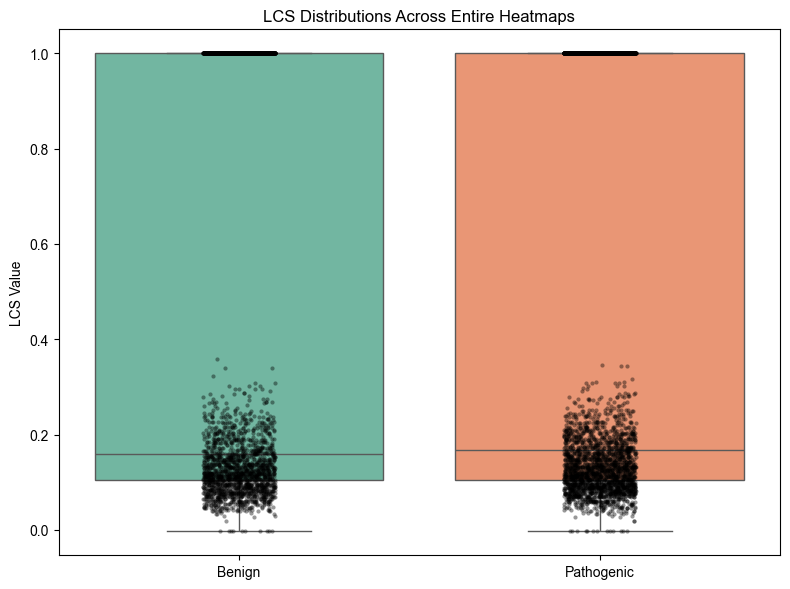

C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\3607641596.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




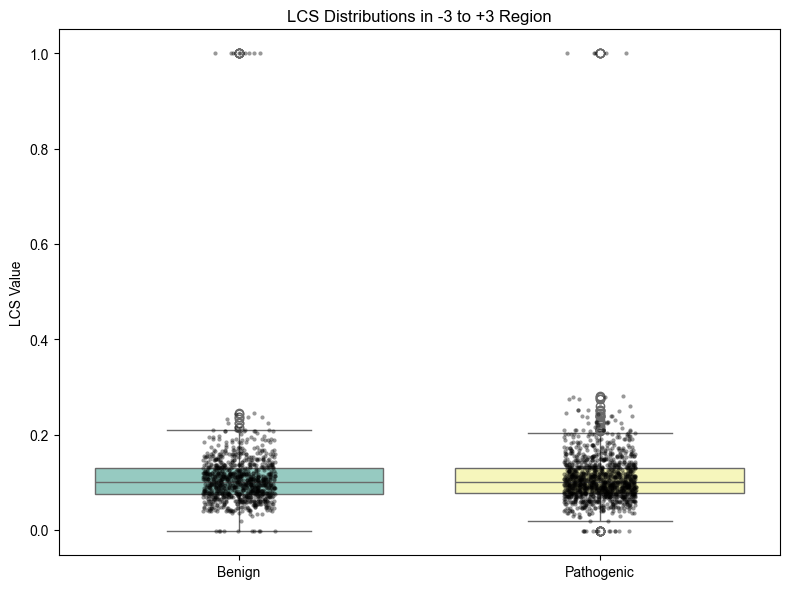

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare full LCS DataFrame for seaborn
df_full = pd.DataFrame({
    'LCS': benign_lcs_full + pathogenic_lcs_full,
    'Group': ['Benign'] * len(benign_lcs_full) + ['Pathogenic'] * len(pathogenic_lcs_full)
})

# Prepare region LCS DataFrame
df_region = pd.DataFrame({
    'LCS': benign_lcs_region + pathogenic_lcs_region,
    'Group': ['Benign'] * len(benign_lcs_region) + ['Pathogenic'] * len(pathogenic_lcs_region)
})

# Plot: Full heatmap LCS
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_full, x='Group', y='LCS', palette='Set2')
sns.stripplot(data=df_full, x='Group', y='LCS', color='black', size=3, jitter=True, alpha=0.4)
plt.title('LCS Distributions Across Entire Heatmaps')
plt.ylabel('LCS Value')
plt.xlabel('')
plt.tight_layout()
plt.show()

# Plot: -3 to +3 region
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_region, x='Group', y='LCS', palette='Set3')
sns.stripplot(data=df_region, x='Group', y='LCS', color='black', size=3, jitter=True, alpha=0.4)
plt.title('LCS Distributions in -3 to +3 Region')
plt.ylabel('LCS Value')
plt.xlabel('')
plt.tight_layout()
plt.show()


In [ ]:
'Top 6 most significantly different mutations to a particular amino acid in benign vs pathogenic groups'

,Mutation,Benign_Mean,Pathogenic_Mean,T_stat,P_value
14,R,0.415686,0.438843,-0.455051,0.649424
4,F,0.417212,0.437868,-0.427267,0.669503
13,Q,0.455347,0.438484,0.352953,0.724392
11,N,0.434204,0.447246,-0.275017,0.783498
19,Y,0.395908,0.406435,-0.228231,0.819616
15,S,0.488598,0.478272,0.215642,0.829426
17,V,0.439963,0.430441,0.197084,0.843903
12,P,0.439110,0.429759,0.186309,0.852342
3,E,0.413613,0.423196,-0.186229,0.852408
7,I,0.442917,0.434059,0.182449,0.855358


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\1403191712.py:68: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\1403191712.py:68: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\1403191712.py:68: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\1403191712.py:68: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the sam

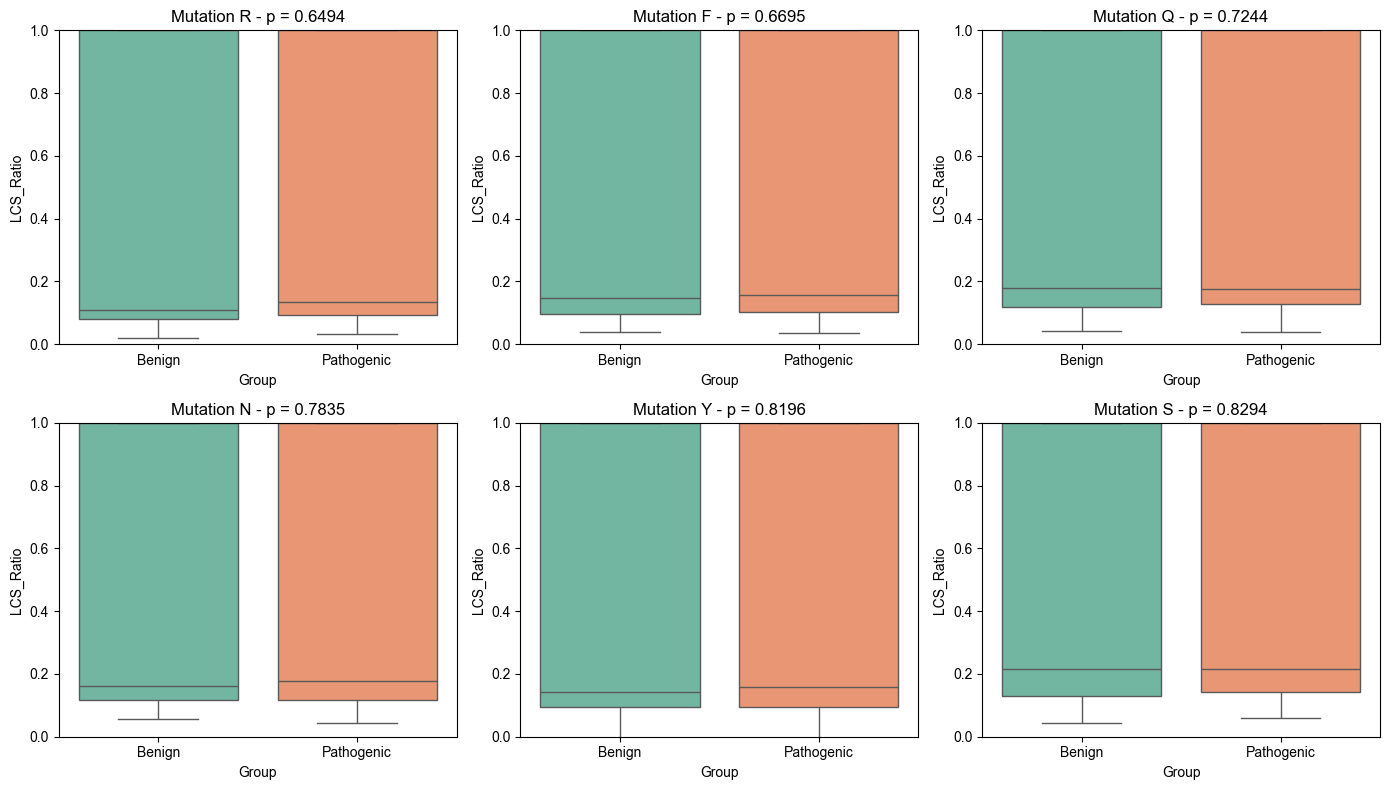

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns


benign_dir = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\benign_mutations2\mutations2"
pathogenic_dir = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\pathogenic_mutations2\mutations2"

def load_heatmap_dfs(directory):
    dfs = []
    for file in os.listdir(directory):
        if file.endswith("_heatmap_data.csv"):
            df = pd.read_csv(os.path.join(directory, file))
            df["file"] = file  # Keep track of origin
            dfs.append(df)
    return dfs

benign_heatmaps = load_heatmap_dfs(benign_dir)
pathogenic_heatmaps = load_heatmap_dfs(pathogenic_dir)

# --- Aggregate LCS values by Mutation (Amino Acid) ---
def collect_lcs_by_mutation(heatmap_list):
    all_data = []
    for df in heatmap_list:
        for _, row in df.iterrows():
            all_data.append((row["Mutation"], row["LCS_Ratio"]))
    return pd.DataFrame(all_data, columns=["Mutation", "LCS_Ratio"])

benign_data = collect_lcs_by_mutation(benign_heatmaps)
benign_data["Group"] = "Benign"

pathogenic_data = collect_lcs_by_mutation(pathogenic_heatmaps)
pathogenic_data["Group"] = "Pathogenic"

combined = pd.concat([benign_data, pathogenic_data], ignore_index=True)

# --- Perform per-substitution statistical comparison ---
results = []
mutations = sorted(combined["Mutation"].dropna().unique())

for mut in mutations:
    benign_vals = benign_data[benign_data["Mutation"] == mut]["LCS_Ratio"].dropna()
    path_vals = pathogenic_data[pathogenic_data["Mutation"] == mut]["LCS_Ratio"].dropna()
    
    if len(benign_vals) > 1 and len(path_vals) > 1:
        t_stat, p_val = ttest_ind(benign_vals, path_vals, equal_var=False)
        results.append({
            "Mutation": mut,
            "Benign_Mean": benign_vals.mean(),
            "Pathogenic_Mean": path_vals.mean(),
            "T_stat": t_stat,
            "P_value": p_val
        })

results_df = pd.DataFrame(results).sort_values("P_value")
display(results_df.head(10))  # Show top 10 amino acid substitutions with most significant differences

# --- Plot top N most significant amino acid substitutions as boxplots ---
top_mutations = results_df.nsmallest(6, "P_value")["Mutation"].tolist()

plt.figure(figsize=(14, 8))
for i, mut in enumerate(top_mutations):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=combined[combined["Mutation"] == mut], x="Group", y="LCS_Ratio", palette="Set2")
    plt.title(f"Mutation {mut} - p = {results_df[results_df.Mutation == mut]['P_value'].values[0]:.4f}")
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()


In [ ]:
'Top 6 most significantly different positions for mutations in benign vs pathogenic groups'

c:\Users\ricea\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



,Position,Benign_Mean,Pathogenic_Mean,T_stat,P_value
2,3,0.144609,0.166175,-3.240373,0.001295
6,7,0.109879,0.124654,-2.753463,0.006170
4,5,0.132652,0.152025,-1.818681,0.069654
8,9,0.115040,0.095803,1.777984,0.076551
5,6,0.098263,0.111971,-1.744194,0.081835
9,10,0.115789,0.103743,1.607875,0.109233
3,4,0.181996,0.167944,1.559886,0.119723
10,11,0.127900,0.120632,0.854359,0.393527
7,8,0.031877,0.037341,-0.415344,0.679999
11,12,0.174417,0.173185,0.129176,0.897286


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4011246123.py:79: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4011246123.py:79: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4011246123.py:79: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\4011246123.py:79: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the sam

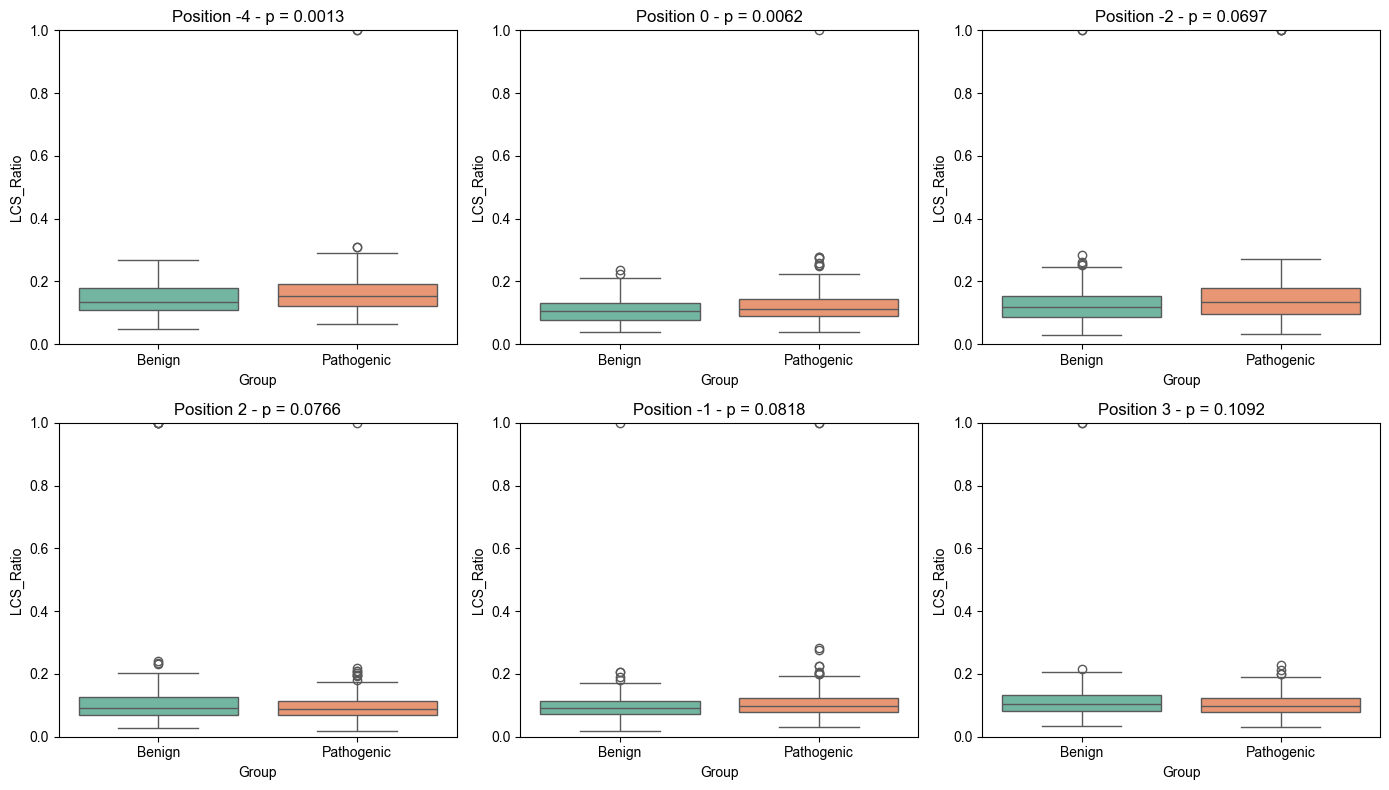

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns


benign_dir = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\benign_mutations2\mutations2"
pathogenic_dir = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\pathogenic_mutations2\mutations2"


def load_heatmap_dfs(directory):
    dfs = []
    for file in os.listdir(directory):
        if file.endswith("_heatmap_data.csv"):
            df = pd.read_csv(os.path.join(directory, file))
            df["file"] = file  # Keep track of origin
            dfs.append(df)
    return dfs

benign_heatmaps = load_heatmap_dfs(benign_dir)
pathogenic_heatmaps = load_heatmap_dfs(pathogenic_dir)

# --- Aggregate LCS values by Position across all heatmaps ---
def collect_lcs_by_position(heatmap_list):
    all_data = []
    for df in heatmap_list:
        for _, row in df.iterrows():
            all_data.append((row["Position"], row["LCS_Ratio"]))
    return pd.DataFrame(all_data, columns=["Position", "LCS_Ratio"])

benign_data = collect_lcs_by_position(benign_heatmaps)
benign_data["Group"] = "Benign"

pathogenic_data = collect_lcs_by_position(pathogenic_heatmaps)
pathogenic_data["Group"] = "Pathogenic"

combined = pd.concat([benign_data, pathogenic_data], ignore_index=True)

# --- Adjust Position values to the new notation (Position 7 becomes 0, etc.) ---
combined["Adjusted_Position"] = combined["Position"] - 7  # Shift positions so 7 becomes 0

# --- Perform per-position statistical comparison ---
results = []
positions = sorted(combined["Position"].dropna().unique())

for pos in positions:
    benign_vals = benign_data[benign_data["Position"] == pos]["LCS_Ratio"].dropna()
    path_vals = pathogenic_data[pathogenic_data["Position"] == pos]["LCS_Ratio"].dropna()
    
    if len(benign_vals) > 1 and len(path_vals) > 1:
        t_stat, p_val = ttest_ind(benign_vals, path_vals, equal_var=False)
        results.append({
            "Position": pos,
            "Benign_Mean": benign_vals.mean(),
            "Pathogenic_Mean": path_vals.mean(),
            "T_stat": t_stat,
            "P_value": p_val
        })

results_df = pd.DataFrame(results).sort_values("P_value")
display(results_df.head(10))  # Show the regions with most significant differences

# --- Plot top N most significant positions as boxplots ---
top_positions = results_df.nsmallest(6, "P_value")["Position"].tolist()

plt.figure(figsize=(14, 8))
for i, pos in enumerate(top_positions):
    plt.subplot(2, 3, i+1)
    
    # Adjust positions to -7 to +7 range
    adjusted_pos = pos - 7  # Convert position to adjusted notation (7 -> 0, 15 -> +7, etc.)
    
    # Filter the data for the current adjusted position
    region_data = combined[combined["Adjusted_Position"] == adjusted_pos]
    
    # Create the boxplot
    sns.boxplot(data=region_data, x="Group", y="LCS_Ratio", palette="Set2")
    
    # Get the p-value for the current position
    p_value = results_df[results_df["Position"] == pos]["P_value"].values[0]
    plt.title(f"Position {adjusted_pos} - p = {p_value:.4f}")
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()


In [ ]:
'Show lowest LCS values in benign and pathogenic groups - highest impact mutations'

In [30]:
import pandas as pd

# Function to remap position from 0-15 range to -7 to +7 range
def remap_position(position):
    return position - 7

# Assuming 'benign_data' and 'pathogenic_data' contain the data for both groups

# Apply the remap function to adjust positions
benign_data["Adjusted_Position"] = benign_data["Position"].apply(remap_position)
pathogenic_data["Adjusted_Position"] = pathogenic_data["Position"].apply(remap_position)

# Calculate average LCS for each adjusted position in benign and pathogenic groups
benign_avg_lcs = benign_data.groupby("Adjusted_Position")["LCS_Ratio"].mean().sort_values()
pathogenic_avg_lcs = pathogenic_data.groupby("Adjusted_Position")["LCS_Ratio"].mean().sort_values()

# Display the position with the lowest average LCS value for each group (on -7 to +7 scale)
lowest_benign_position = benign_avg_lcs.idxmin()  # Position with lowest average LCS for benign
lowest_benign_lcs = benign_avg_lcs.min()  # Lowest average LCS value for benign

lowest_pathogenic_position = pathogenic_avg_lcs.idxmin()  # Position with lowest average LCS for pathogenic
lowest_pathogenic_lcs = pathogenic_avg_lcs.min()  # Lowest average LCS value for pathogenic

# Output the results
print(f"Benign - Position {lowest_benign_position} has the lowest average LCS: {lowest_benign_lcs:.4f}")
print(f"Pathogenic - Position {lowest_pathogenic_position} has the lowest average LCS: {lowest_pathogenic_lcs:.4f}")

# Optionally, if you want to look at the top N lowest positions:
top_n_benign = benign_avg_lcs.head(10)  # top 10 lowest positions for benign
top_n_pathogenic = pathogenic_avg_lcs.head(10)  # top 10 lowest positions for pathogenic

print("\nTop 10 positions with lowest average LCS in Benign group:")
print(top_n_benign)

print("\nTop 10 positions with lowest average LCS in Pathogenic group:")
print(top_n_pathogenic)


Benign - Position 1 has the lowest average LCS: 0.0319
Pathogenic - Position 1 has the lowest average LCS: 0.0373

Top 10 positions with lowest average LCS in Benign group:
Adjusted_Position
 1    0.031877
-1    0.098263
 0    0.109879
 2    0.115040
 3    0.115789
 4    0.127900
-2    0.132652
-4    0.144609
 5    0.174417
-3    0.181996
Name: LCS_Ratio, dtype: float64

Top 10 positions with lowest average LCS in Pathogenic group:
Adjusted_Position
 1    0.037341
 2    0.095803
 3    0.103743
-1    0.111971
 4    0.120632
 0    0.124654
-2    0.152025
-4    0.166175
-3    0.167944
 5    0.173185
Name: LCS_Ratio, dtype: float64


In [ ]:
'Mutations at Position 1 have the lowest LCS (highest impact) in both groups with no significant difference between the two'

C:\Users\ricea\AppData\Local\Temp\ipykernel_26764\1695089195.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




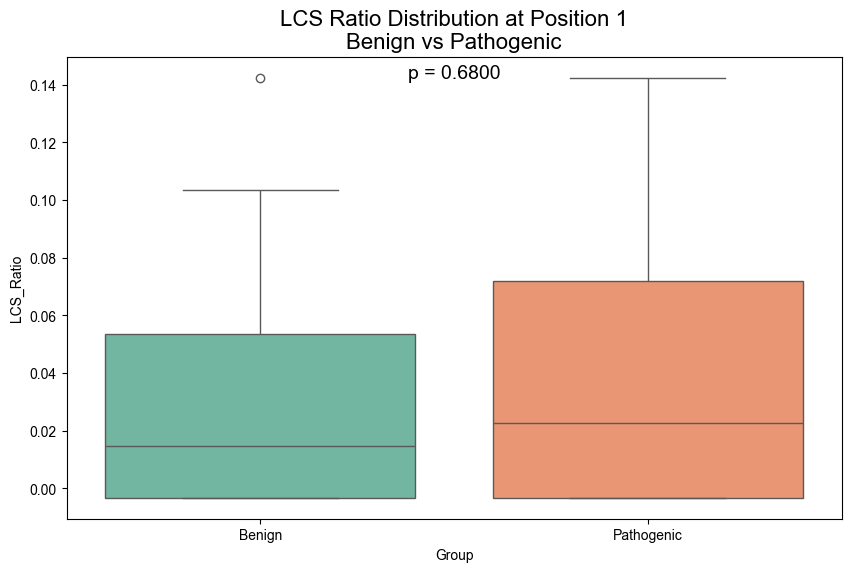

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Filter the data for Position 1 in both benign and pathogenic groups
benign_position_1 = benign_data[benign_data["Adjusted_Position"] == 1]
pathogenic_position_1 = pathogenic_data[pathogenic_data["Adjusted_Position"] == 1]

# Combine the two dataframes for side-by-side boxplot
combined_position_1 = pd.concat([benign_position_1, pathogenic_position_1])

# Perform t-test
benign_vals = benign_position_1["LCS_Ratio"].dropna()
pathogenic_vals = pathogenic_position_1["LCS_Ratio"].dropna()

t_stat, p_val = ttest_ind(benign_vals, pathogenic_vals, equal_var=False)

# Plot side-by-side boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(x="Group", y="LCS_Ratio", data=combined_position_1, palette="Set2")

# Set title
plt.title("LCS Ratio Distribution at Position 1\nBenign vs Pathogenic", fontsize=16)

# Annotate the p-value on the plot
plt.text(0.5, max(combined_position_1["LCS_Ratio"]), f'p = {p_val:.4f}', horizontalalignment='center', fontsize=14)

# Display the plot
plt.show()
